<a href="https://colab.research.google.com/github/11nils11/test-3-/blob/main/Kopie_von_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
import os

In [ ]:
pip install colorama

In [ ]:
from colorama import Fore, Back, Style

# Model

In [ ]:
# Model setup
class CNN(nn.Module):
  def __init__(self, input_channels = 3, num_classes = 43):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 6, kernel_size = 5)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(120, 84)
    self.dropout2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = self.fc3(x)
    return x

In [ ]:
# Test model dimensions
model = CNN()
x = torch.rand(64 , 3 , 30 , 30)
print(model(x).shape)

torch.Size([64, 43])


In [ ]:
# Set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_channels = 3 #RGB
num_classes = 43
learning_rate = 0.001
batch_size = 64
epochs = 100


# **Load whole dataset and split into Train, Validation and Calibration**

In [ ]:
# Load data
data_transforms = transforms.Compose([
    transforms.Resize([30, 30]),
    transforms.ToTensor()
    ])

train_dataset = datasets.GTSRB(root='./dataset', split = 'train', transform = data_transforms, download = True)
test_dataset = datasets.GTSRB(root='./dataset', split = 'test', transform= data_transforms, download = True)

# combine dataset
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
dataset = ConcatDataset([train_dataset, test_dataset])
print(len(train_dataset), len(test_dataset), len(dataset))


# Split data
trainset, valset, calset = random_split(dataset, [0.8,0.1,0.1])
train_loader = DataLoader(dataset = trainset, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(dataset = valset, batch_size = batch_size, shuffle = False)
cal_loader = DataLoader(dataset = calset, batch_size = batch_size, shuffle = False)
print(len(trainset),len(valset),len(calset))

26640 12630 39270
31416 3927 3927


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Labels


In [ ]:
labels = [
    '20 km/h',
    '30 km/h',
    '50 km/h',
    '60 km/h',
    '70 km/h',
    '80 km/h',
    'End of 80 km/h',
    '100 km/h',
    '120 km/h',
    'No Passing',
    'No Passing for vehicles over 3.5t',
    'Priority at upcoming crossing',
    'Priotrity road starts',
    'yield right-of-way',
    'Stop',
    'No entry',
    'No entry for vehicles over 3.5t',
    'Do not enter',
    'Warning',
    'left turn',
    'right turn',
    'double curve - first to left',
    'Rough road',
    'Slippery road',
    'Narrows from right',
    'Work in process',
    'Traffic signal',
    'Crosswalk',
    'Be aware of children',
    'Be aware of cyclists',
    'Be aware of an icy road',
    'Be aware of wild animals',
    'End of speed limit',
    'Must turn right',
    'Must turn left',
    'Must go straight',
    'Must go straight or turn right',
    'Must go straight or turn left',
    'Drive from the right side of the obstacle',
    'Drive from the left side of the obstacle',
    'Traffic cirlce',
    'End of no passing',
    'End of no passing for vehicles over 3.5t'
]

In [ ]:
# dictionary to convert int labels to text labels
label_dict = {
    '0': '20_speed',
    '1': '30_speed',
    '2': '50_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}

# **"Old" Training (No k-Fold CV / No Dropout)**

In [ ]:
# Init Network
model = CNN(input_channels = input_channels, num_classes = num_classes).to(device)

# Criterion and Loss

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


In [ ]:
model_save_name = 'CNN_100_dropout_05.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
for epoch in range(epochs):
  epoch_loss = 0.0
  running_loss = 0.0
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device)
    targets = targets.to(device)

    #forward
    scores = model(data)
    loss = criterion(scores, targets)

    #backward
    optimizer.zero_grad()
    loss.backward()

    #gradient descend
    optimizer.step()

    #loss while training
    epoch_loss += scores.shape[0] * loss.item()
    running_loss += loss.item()
    #print running loss
    if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 100))
            running_loss = 0.0

  #print epoch loss
  print(epoch+1, epoch_loss / len(train_dataset))

[1,   100] loss: 0.137
[1,   200] loss: 0.104
[1,   300] loss: 0.111
[1,   400] loss: 0.089
1 0.13566625787884937
[2,   100] loss: 0.116
[2,   200] loss: 0.114
[2,   300] loss: 0.111
[2,   400] loss: 0.104
2 0.13309466044275878
[3,   100] loss: 0.105
[3,   200] loss: 0.111
[3,   300] loss: 0.109
[3,   400] loss: 0.109
3 0.13110769657703403
[4,   100] loss: 0.111
[4,   200] loss: 0.109
[4,   300] loss: 0.110
[4,   400] loss: 0.100
4 0.12567399056644427
[5,   100] loss: 0.092
[5,   200] loss: 0.099
[5,   300] loss: 0.110
[5,   400] loss: 0.117
5 0.12530291898920012
[6,   100] loss: 0.110
[6,   200] loss: 0.085
[6,   300] loss: 0.093
[6,   400] loss: 0.089
6 0.11512135255175668
[7,   100] loss: 0.101
[7,   200] loss: 0.101
[7,   300] loss: 0.108
[7,   400] loss: 0.096
7 0.11828457560983148
[8,   100] loss: 0.098
[8,   200] loss: 0.093
[8,   300] loss: 0.096
[8,   400] loss: 0.098
8 0.11256769180183185
[9,   100] loss: 0.107
[9,   200] loss: 0.102
[9,   300] loss: 0.094
[9,   400] loss: 0.

# Evaluation method


In [ ]:
def eval_model(loader, model, plot = False, return_critical_points = False, return_accuracy = False):

  num_correct = 0
  num_samples = 0
  y_pred = []
  y_true = []
  model.eval()

  critical_points = []
  i = 0

  with torch.no_grad():
    for inputs, classes in loader:
      inputs = inputs.to(device=device)
      classes = classes.to(device=device)

      scores = model(inputs)
      _, predictions = scores.max(1)
      num_correct += (predictions == classes).sum()
      num_samples += predictions.size(0)

      #critical_points
      if return_critical_points:
        for j, p in enumerate(predictions):
          if not p == classes[j]:
            critical_points.append(i)
          i+=1

      if plot:
        outputs = (torch.max(torch.exp(scores), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs)
        classes = classes.data.cpu().numpy()
        y_true.extend(classes)

    if return_accuracy:
      return float(num_correct)/float(num_samples)*100
    else:
      print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    if plot:
      cm = confusion_matrix(y_true, y_pred)
      df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None])
      plt.figure(figsize = (30,15))
      sn.heatmap(df_cm, annot=True)
      plt.show()

  model.train()

  if return_critical_points:
    return critical_points


In [ ]:
model_save_name = 'CNN_100_dropout_05.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)

Got 31331 / 31416 with accuracy 99.73
Got 3872 / 3927 with accuracy 98.60
Got 3872 / 3927 with accuracy 98.60


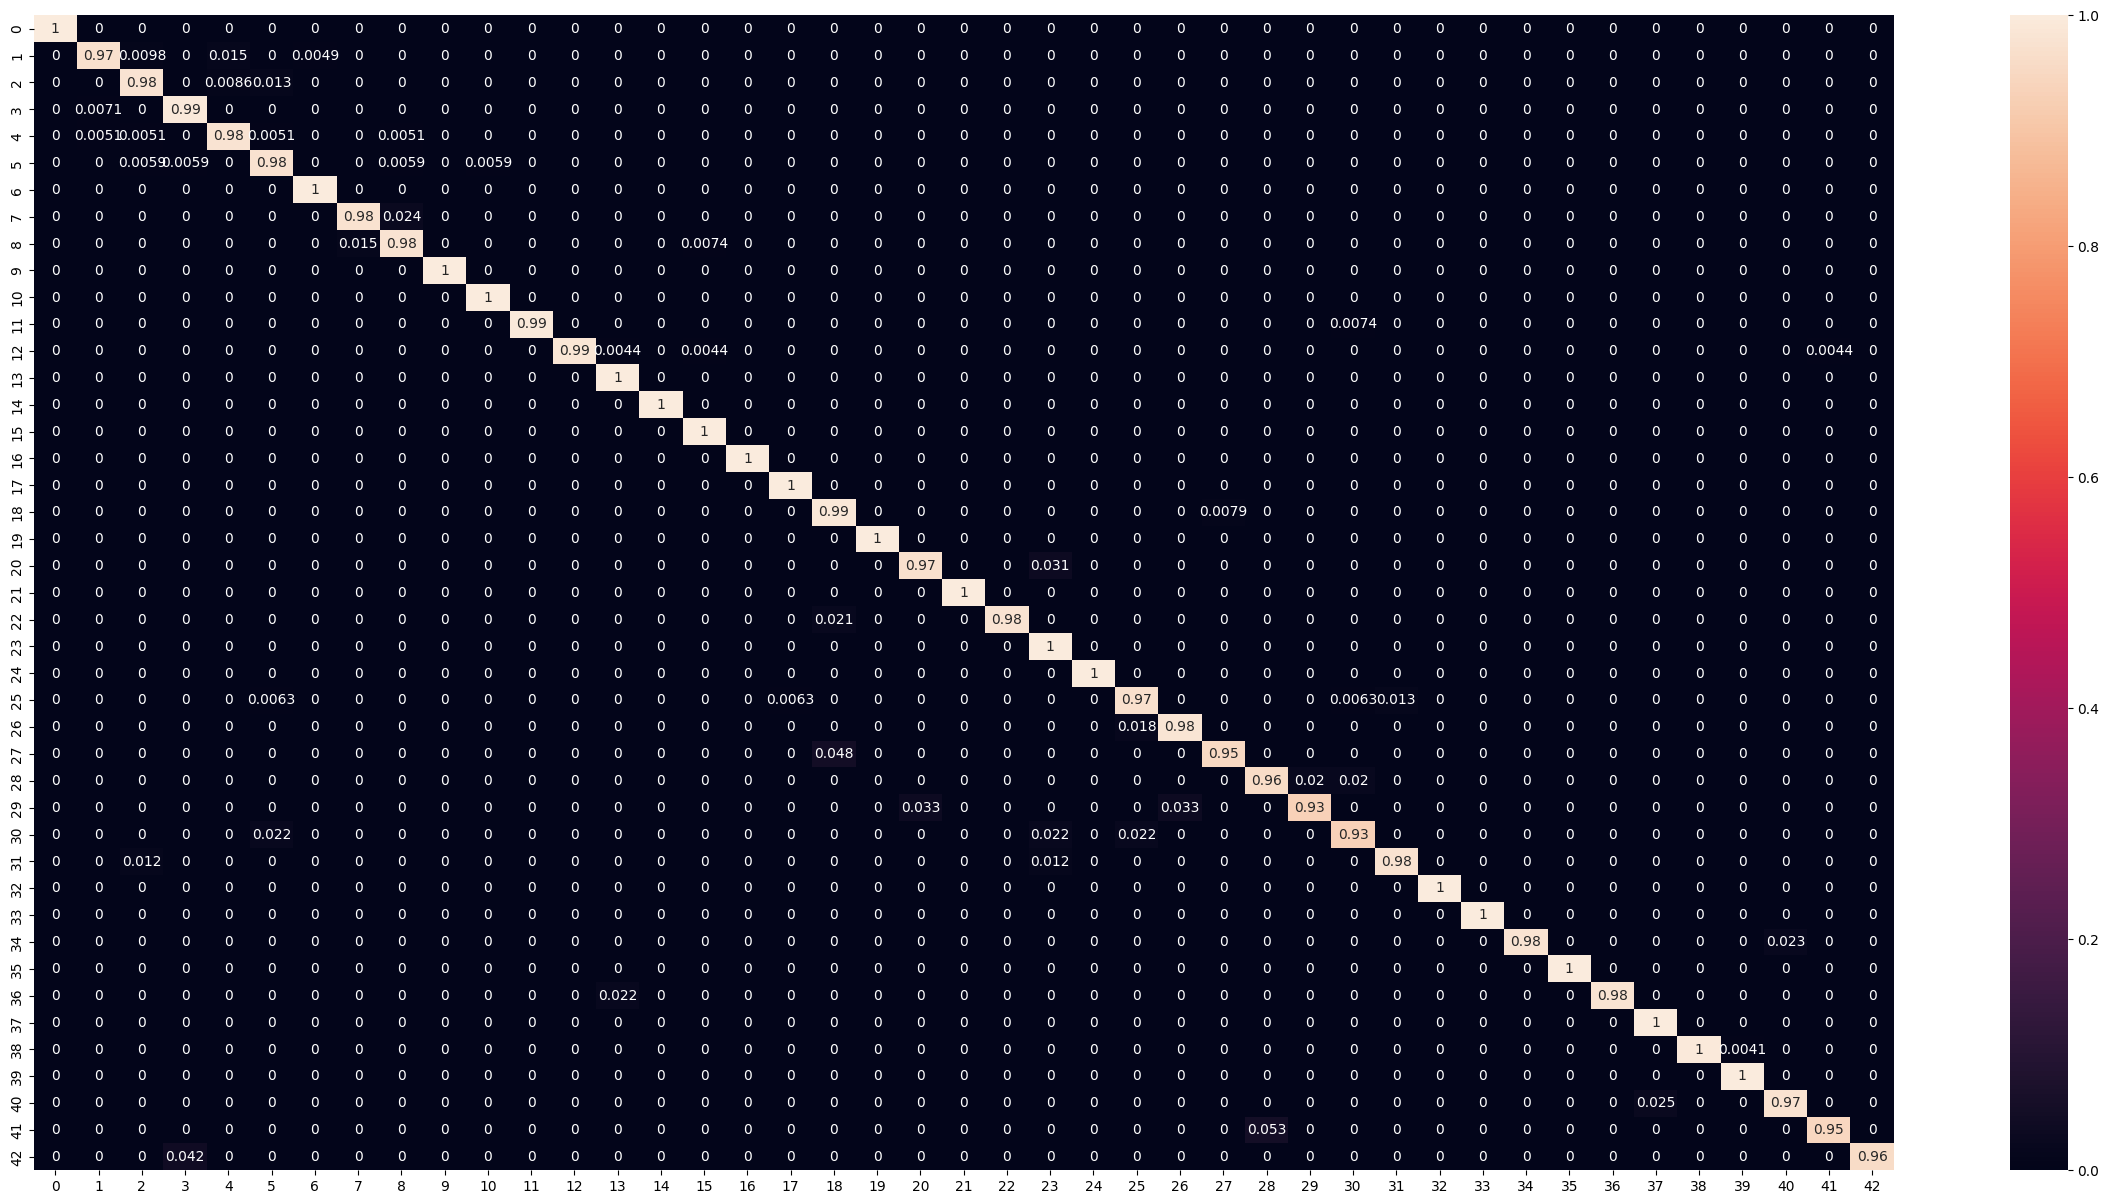

Got 3872 / 3927 with accuracy 98.60
[0, 86, 208, 295, 299, 315, 344, 384, 418, 724, 744, 829, 834, 860, 900, 917, 1036, 1076, 1148, 1169, 1235, 1285, 1423, 1460, 1463, 1497, 1628, 1720, 1785, 1839, 2072, 2078, 2107, 2144, 2264, 2271, 2285, 2311, 2604, 2620, 2638, 2702, 2767, 2816, 3025, 3203, 3312, 3323, 3492, 3509, 3523, 3568, 3702, 3812, 3858]
98.59943977591037


In [ ]:
eval_model(train_loader, model)
eval_model(val_loader, model)
eval_model(val_loader, model, plot = True)
accuracy = eval_model(val_loader, model, return_accuracy = True)
crit = eval_model(val_loader, model, return_critical_points = True)
print(crit)
print(accuracy)

# Validation

In [ ]:
val_loader = DataLoader(dataset = valset, batch_size = batch_size, shuffle = False)
critical_points = eval_model(val_loader, model, return_critical_points = True)


Got 3872 / 3927 with accuracy 98.60


# Data methods


In [ ]:
def get_distribution(loader):
  distribution = [0 for i in range(num_classes)]
  for data, target in loader:
    for y in target:
      distribution[y] +=1
  return distribution

In [77]:
def plot_distribution(dist, labels, title = ""):
  plt.rcdefaults()
  plt.figure(figsize=(20,6))
  plt.title(title)
  plt.xticks(range(len(labels)), labels, rotation=90)
  x = [i for i in range(len(labels))]

  plt.bar(x, dist)
  plt.show()

In [78]:
def plot_relative_distribution(dist, total_dist, labels, title = ""):
  plt.rcdefaults()
  new_dist = []

  label_index = []
  for i, td in enumerate(total_dist):
    if td != 0:
      new_dist.append(dist[i] / td)
      label_index.append(i)

  plt.figure(figsize=(20,6))
  plt.title(title)

  if len(labels) == len(label_index):
    plt.xticks([i for i in range(len(labels))], labels, rotation=90)
    x = [i for i in range(len(labels))]
  else:
    labels_subset = []
    for idx in label_index:
      labels_subset.append(labels[idx])

    plt.xticks([i for i in range(len(labels_subset))], labels_subset, rotation = 90)
    x = [i for i in range(len(labels_subset))]
  plt.plot(x, new_dist)
  plt.show()

In [ ]:
total_loader = DataLoader(dataset = dataset, batch_size = len(calset), shuffle = False)
total_dist = get_distribution(total_loader)

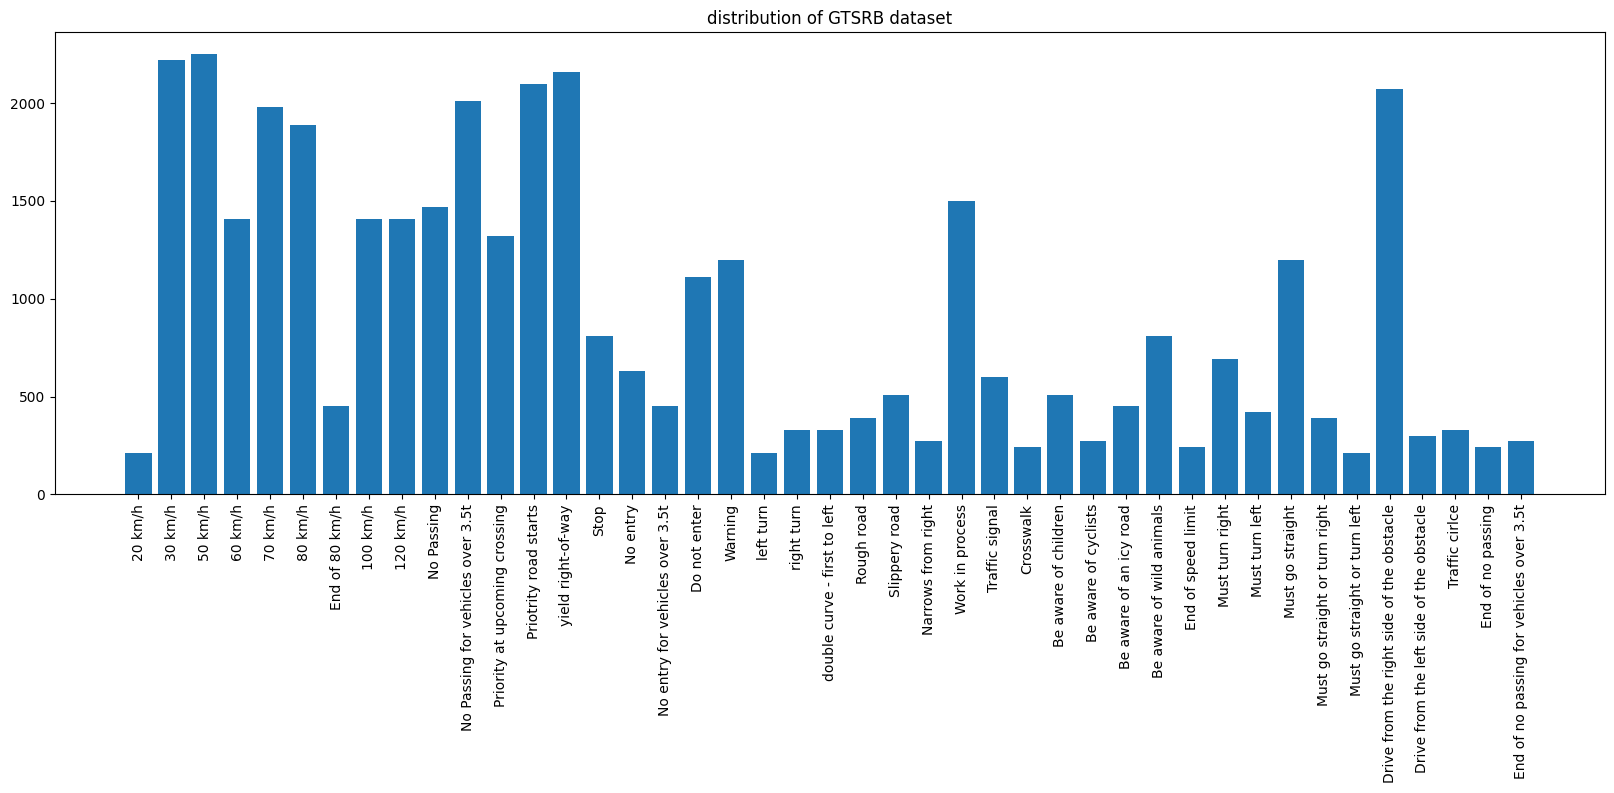

In [ ]:
plot_distribution(total_dist, labels, "distribution of GTSRB dataset")

# Calibration


In [ ]:
cal_loader = DataLoader(dataset = calset, batch_size = len(calset), shuffle = False)
cal_dist = get_distribution(cal_loader)

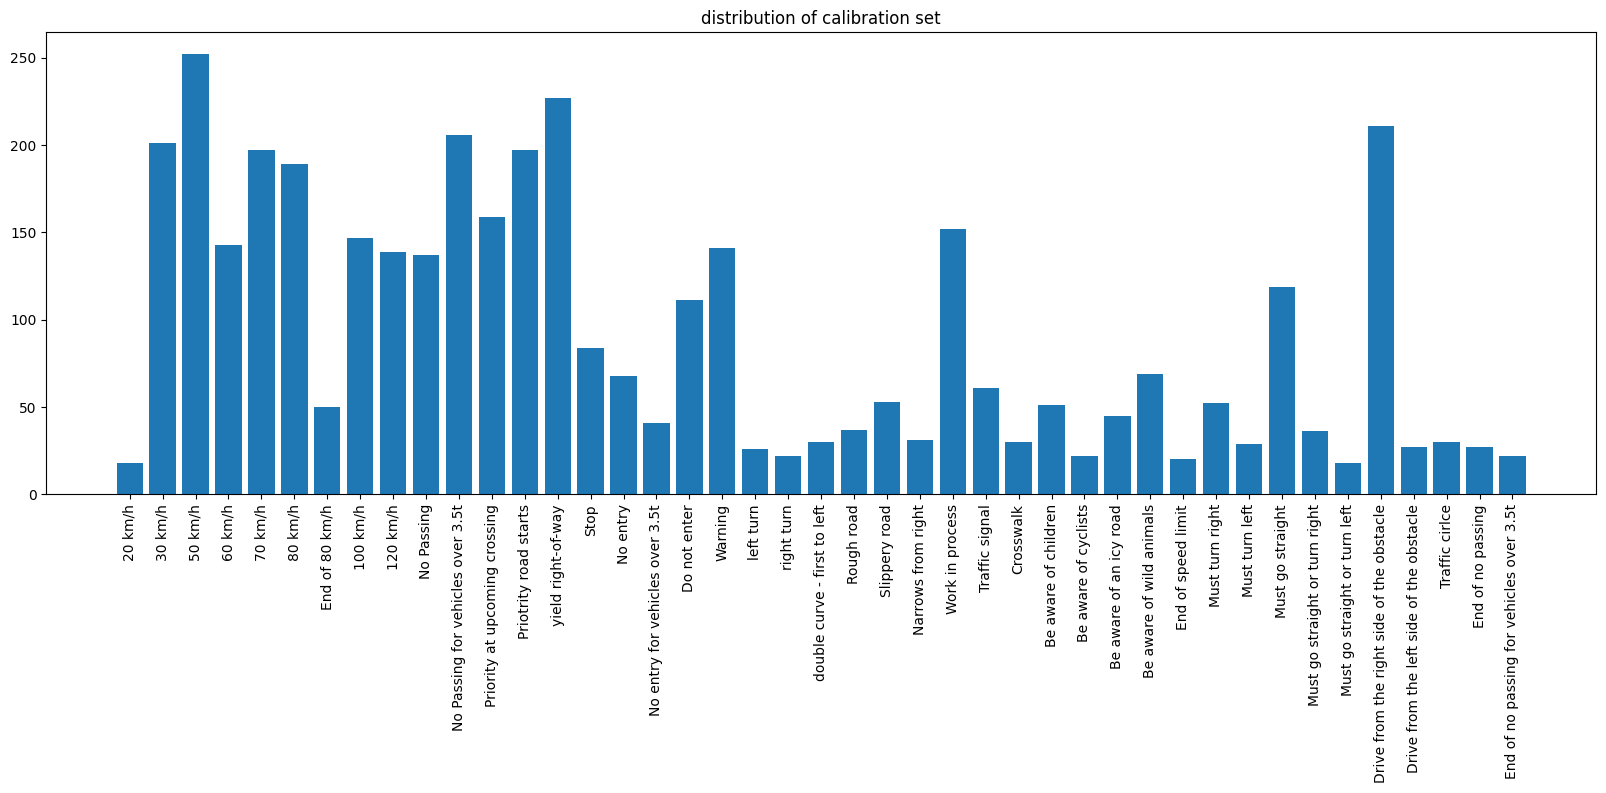

In [ ]:
plot_distribution(cal_dist, labels, "distribution of calibration set")

In [ ]:
n_cal = len(calset)

In [ ]:
softm = nn.Softmax(dim = 1)

In [ ]:
def get_smx_and_labels(loader):
  smx = []
  true_labels = []
  for data, target in loader:
    data = data.to(device = device)
    target = target.to(device = device)

    #get softmax(smx) values for all 43 classes
    out = model(data)
    smx_scores = softm(out)
    smx_scores = smx_scores.cpu().data.numpy()

    for array in smx_scores:
      a = array.tolist()
      smx.append(a)

    #get true class
    for label in target:
      label = label.item()
      true_labels.append(label)

  return np.array(smx), np.array(true_labels)

In [ ]:
def calc_scores(cal_smx, cal_true_labels):
  return 1-cal_smx[np.arange(n_cal),cal_true_labels]

In [ ]:
def calc_qhat(cal_loader, alpha):
  cal_smx, cal_true_labels = get_smx_and_labels(cal_loader)
  cal_scores = calc_scores(cal_smx, cal_true_labels)
  q_level = np.ceil((n_cal+1)* (1-alpha))/n_cal
  q_hat = np.quantile(cal_scores, q_level, interpolation= 'higher')
  return q_hat

In [ ]:
def get_prediction_sets(data_smx, q_hat):
  return data_smx >= (1-q_hat)

In [ ]:
def get_average_prediction_set_size(idx, prediction_sets):

  avg = 0.0
  for i in idx:
    prediction_set = np.array(prediction_sets[i])
    avg += prediction_set.sum()
  avg = avg / len(idx)
  return avg


In [ ]:
def get_in_set(prediction_set, true_label_id):
  return prediction_set[true_label_id]

In [ ]:
def get_sorted_prediction_set(prediction_set, data_smx, img_id):

  lst = []

  for i, b in enumerate(prediction_set):
    if b:
      t = (data_smx[img_id,i], i)
      lst.append(t)
  lst.sort(key=lambda tup: tup[0], reverse = True)
  return lst

In [ ]:
def plot_alpha_vs_setsize(alphas, data_smx, dataset):
  plt.rcdefaults()
  avgs = []
  for a in alphas:
    q_h = calc_qhat(cal_loader, a)
    prediction_sets = get_prediction_sets(data_smx, q_h)
    avg = get_average_prediction_set_size(range(len(dataset)), prediction_sets)
    avgs.append(avg)
  plt.title("error rate vs set size", fontsize = 25)
  plt.xlabel("alpha", fontsize = 25)
  plt.ylabel("average set size", fontsize = 25)
  plt.plot(alphas, avgs)
  plt.yticks(np.arange(0,10,1), ["", "1", "", "3", "", "5", "", "7", "", "9"])
  plt.tick_params(axis='y', labelsize=20)
  plt.tick_params(axis='x', labelsize=20)
  plt.grid()
  plt.show()

In [ ]:
def visualize_calibration(cal_smx, cal_true_labels, scores, labels,  q_hat):
  plt.rcdefaults()
  m = 0
  img_id = 0
  prediction_sets = get_prediction_sets(cal_smx, q_hat)

  for i , p_set in enumerate(prediction_sets):
    if p_set.sum() in [6,7,8,9]:
      m = p_set.sum()
      img_id = i
  if img_id == 0:
    print("rip")
    for i , p_set in enumerate(prediction_sets):
      if p_set.sum() > m:
        m = p_set.sum()
        img_id = i

  fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(30, 6), )
  fig.suptitle('Conformal prediction', fontsize = 35)

  #ax1.set_xticks(range(len(labels)), labels, rotation=90)
  ax1.set_xticks([])
  ax1.tick_params(axis='y', labelsize=20)
  ax1.set_yscale("log")
  ax1.set_xlabel("classes", fontsize = 25)
  ax1.set_ylabel("softmax", fontsize = 25)
  x = [i for i in range(len(labels))]
  ax1.bar(x, cal_smx[img_id])[cal_true_labels[img_id]].set_color('r')
  ax1.axhline(y = 1 - scores[img_id], color = 'r', linestyle = '--', label = "1 - true_smx")
  ax1.legend(bbox_to_anchor = (0.85, 0.9), loc = 'upper center',prop={"size":16})

  #count = Counter(scores)
  #ax2.set_ylabel("#")
  #ax2.set_xlabel("scores")
  #ax2.set_yscale("log")
  #ax2.set_xscale("log")
  #ax2.bar(count.keys(), count.values(), width = 1/ len(count))
  #ax2.axvline(x = q_hat, color = 'r', linestyle = '--', label = "q_hat")
  #ax2.legend(bbox_to_anchor = (0.9, 0.9), loc = 'upper center')

  #ax3.set_xticks(range(len(labels)), labels, rotation=90)
  ax3.set_xticks([])
  ax3.set_yscale("log")
  ax3.tick_params(axis='y', labelsize=20)
  ax3.set_ylabel("softmax", fontsize = 25)
  ax3.set_xlabel("classes", fontsize = 25)
  x = [i for i in range(len(labels))]
  bar = ax3.bar(x, cal_smx[img_id])
  for i, b in enumerate(prediction_sets[img_id]):
    if b:
      bar[i].set_color('c')
  bar[cal_true_labels[img_id]].set_color('r')
  ax3.axhline(y = 1 - q_hat, color = 'r', linestyle = '--', label = "1 - q_hat")
  ax3.legend(bbox_to_anchor = (0.9, 0.95), loc = 'upper center',prop={"size":16})


In [ ]:
q_hat = calc_qhat(cal_loader, 0.005)
print(q_hat)

tensor([[1.1542e-19, 7.2352e-08, 6.5266e-02,  ..., 1.0709e-18, 1.6838e-12,
         6.5481e-06],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [7.7379e-31, 4.4539e-37, 4.1134e-31,  ..., 0.0000e+00, 9.7467e-39,
         6.6926e-36],
        ...,
        [0.0000e+00, 0.0000e+00, 1.2784e-30,  ..., 0.0000e+00, 3.2090e-43,
         0.0000e+00],
        [4.4476e-19, 1.1788e-07, 9.9989e-01,  ..., 4.3462e-29, 1.4213e-22,
         6.9969e-30],
        [0.0000e+00, 1.9824e-33, 3.2161e-20,  ..., 0.0000e+00, 6.9384e-28,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
0.9999599912371195


<ipython-input-35-ab075ffb1536>:5: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  q_hat = np.quantile(cal_scores, q_level, interpolation= 'higher')


In [ ]:
cal_smx, cal_true_labels, = get_smx_and_labels(cal_loader)

tensor([[2.1361e-17, 2.3541e-07, 1.3691e-05,  ..., 6.2965e-14, 2.9550e-09,
         3.6476e-01],
        [0.0000e+00, 0.0000e+00, 2.1906e-40,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.9761e-35, 2.3892e-34, 8.3097e-43,  ..., 7.3321e-33, 2.2076e-21,
         2.5242e-13],
        ...,
        [3.6948e-36, 3.6529e-41, 5.9145e-17,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.1924e-11, 1.3237e-01, 8.6598e-01,  ..., 1.1579e-16, 1.0991e-12,
         2.9720e-14],
        [1.2536e-21, 1.2035e-15, 9.4518e-12,  ..., 1.5206e-34, 5.9938e-20,
         7.0787e-34]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [79]:
scores = calc_scores(cal_smx, cal_true_labels)

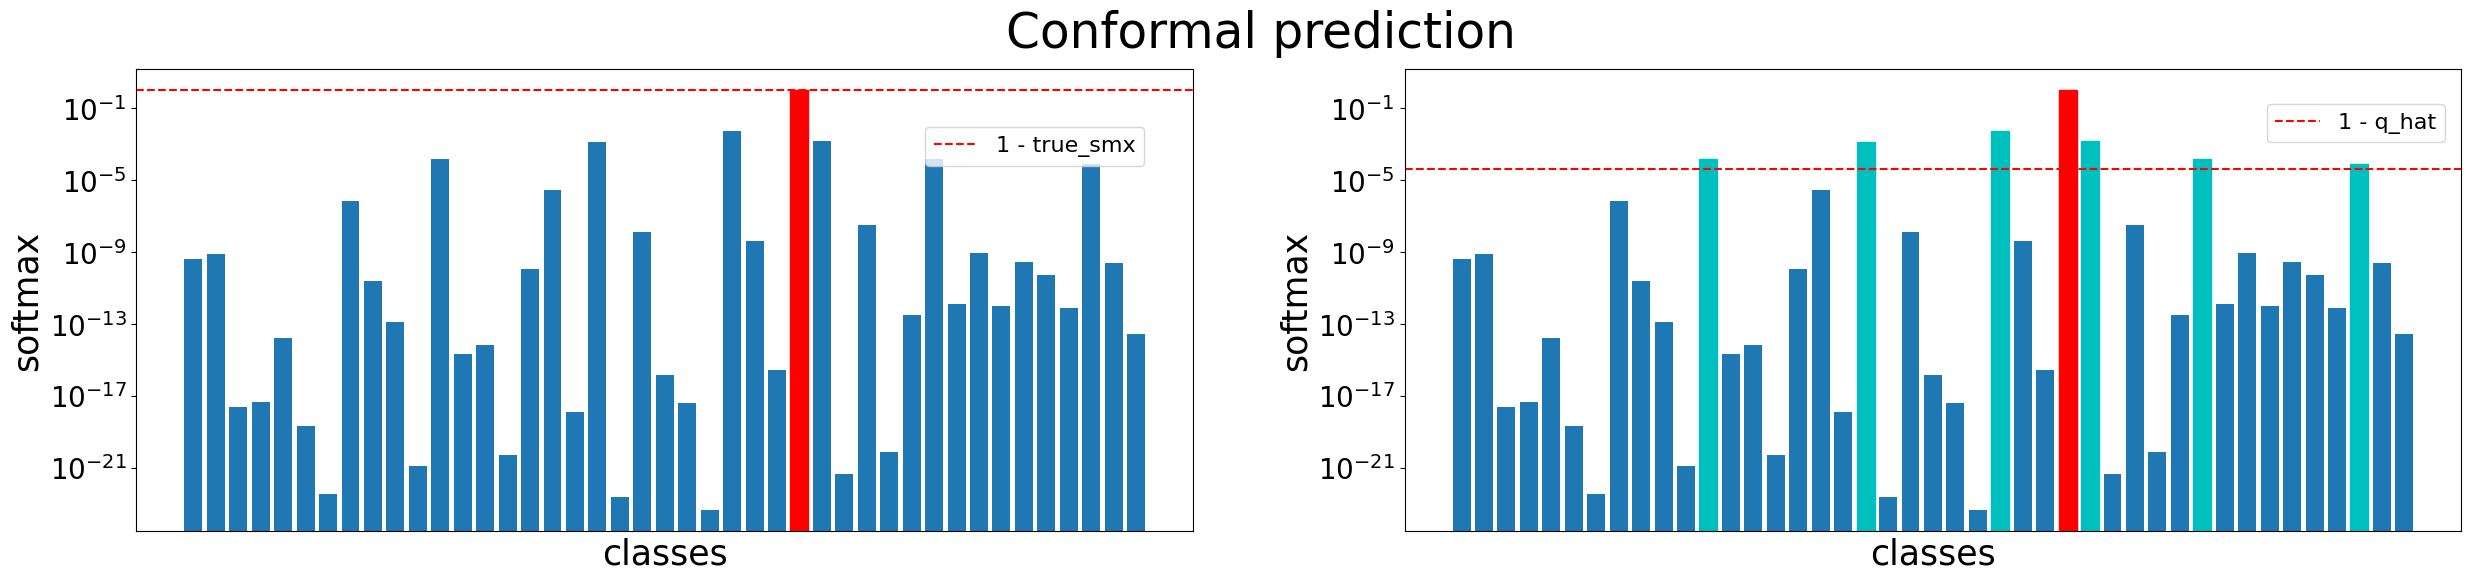

In [ ]:
val_smx, val_true_labels = get_smx_and_labels(val_loader)
visualize_calibration(val_smx, val_true_labels, scores, labels, q_hat)

<ipython-input-35-ab075ffb1536>:5: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  q_hat = np.quantile(cal_scores, q_level, interpolation= 'higher')


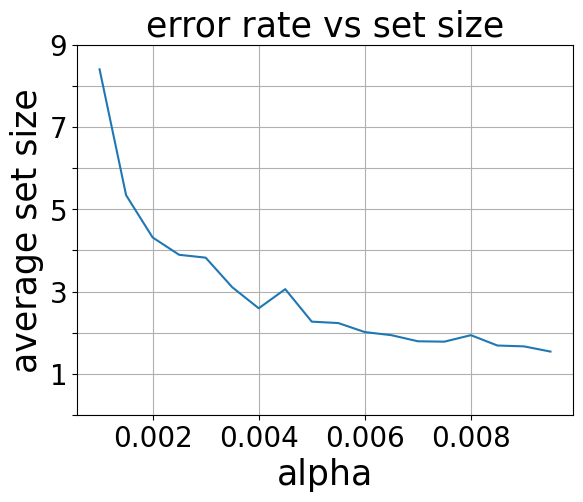

In [ ]:
val_smx, _ = get_smx_and_labels(val_loader)
alphas = np.arange(0.001, 0.01, 0.0005)
plot_alpha_vs_setsize(alphas, val_smx, valset)

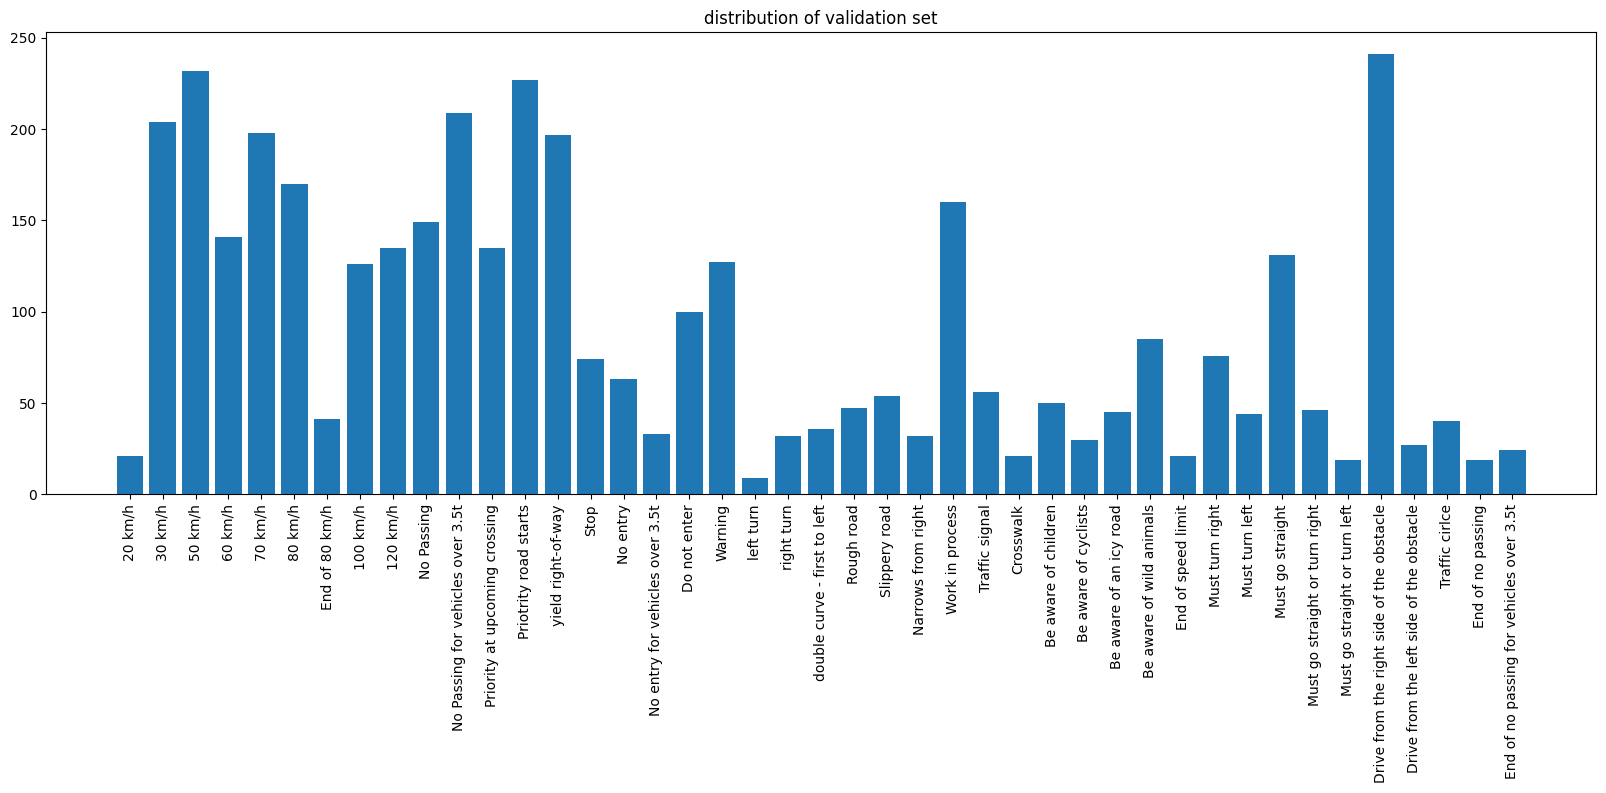

In [ ]:
val_dist = get_distribution(val_loader)
plot_distribution(val_dist, labels, "distribution of validation set")

# Conformal prediction function


In [ ]:
def conformal_prediction(idx, data, data_smx, show_img = True, print_set = True):

  in_set_distribution = [0 for i in range(num_classes)]
  not_in_set_distribution = [0 for i in range(num_classes)]

  prediction_sets = get_prediction_sets(data_smx, q_hat)
  in_set = 0.0

  for i in idx:
    img, true_label_id = data[i]

    if show_img:
      plt.title(labels[true_label_id])
      plt.axis("off")
      img = img.swapaxes(0,1)
      img = img.swapaxes(1,2)
      plt.imshow(img.squeeze(), cmap="gray")
      plt.show()

    prediction_set = prediction_sets[i]

    if print_set:
      if get_in_set(prediction_set, true_label_id):
        s = Fore.GREEN + "prediction set" + Style.RESET_ALL + ": " + Fore.WHITE+ "{"
      else:
        s = Fore.RED + "prediction set" + Style.RESET_ALL + ": " + Fore.WHITE+ "{"
    t = True

    sorted_prediction_set = get_sorted_prediction_set(prediction_set, data_smx, i)

    for (smx, index) in sorted_prediction_set:

      label_string = labels[index]

      if label_string == labels[true_label_id]:
        if print_set:
          label_string = Style.BRIGHT + Fore.YELLOW + labels[index] + Style.RESET_ALL + Fore.WHITE

      if print_set:
        if t:
          s = s + label_string + ": " + str(smx)
          t = False
        else:
          s = s + ", " + label_string + ": " + str(smx)

    if prediction_set[true_label_id]:
      in_set_distribution[true_label_id] += 1
      in_set += 1.0
    else:
      not_in_set_distribution[true_label_id] += 1

    if print_set:
      if show_img:
        print(s+"}")
      else:
        space = ""
        for i in range(50 - len(labels[true_label_id])):
          space += " "
        print(labels[true_label_id] + space + s+"}")
  print("_________________________________________________________________________________________")
  print("We have the probability of "+ Fore.RED + str(in_set/len(idx)) + Style.RESET_ALL +" that the true label is in the prediction set with an average prediction set size of "+ Fore.RED + str(get_average_prediction_set_size(idx, prediction_sets)) + Style.RESET_ALL)

  return in_set_distribution, not_in_set_distribution

# Conformal prediction for critical data points i.e. data points that the model did not predict right.


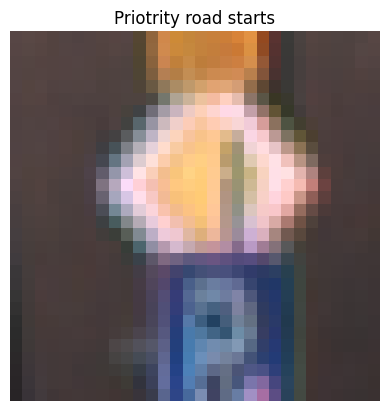

prediction set: {Must turn left: 0.8307105302810669, End of no passing: 0.06324995309114456, Priority at upcoming crossing: 0.056408315896987915, End of speed limit: 0.010244790464639664, Be aware of an icy road: 0.008809207007288933, No Passing: 0.0069404649548232555, Must go straight: 0.0067340899258852005, No entry for vehicles over 3.5t: 0.0056104171089828014, 60 km/h: 0.004824992269277573, End of no passing for vehicles over 3.5t: 0.003977911081165075, double curve - first to left: 0.0015522866742685437, Drive from the right side of the obstacle: 0.00026588767650537193, Slippery road: 0.0002638844307512045, Traffic cirlce: 0.00011711176193784922, 30 km/h: 6.870155630167574e-05, End of 80 km/h: 6.702674727421254e-05, right turn: 5.24900751770474e-05, No Passing for vehicles over 3.5t: 4.06820145144593e-05}


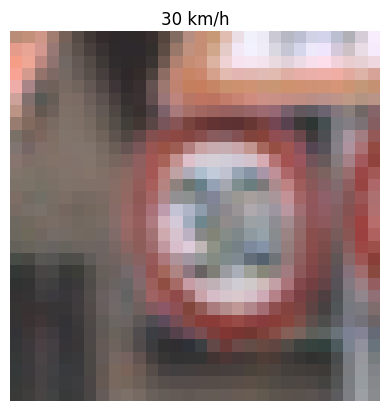

prediction set: {20 km/h: 0.9195175766944885, 30 km/h: 0.0800979807972908, 120 km/h: 0.00021485112665686756, 70 km/h: 0.00016950072313193232}


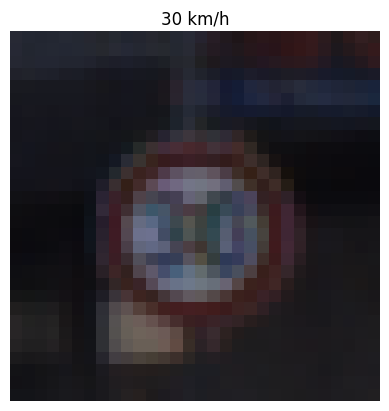

prediction set: {30 km/h: 0.507062554359436, 70 km/h: 0.47568657994270325, 50 km/h: 0.017245246097445488}


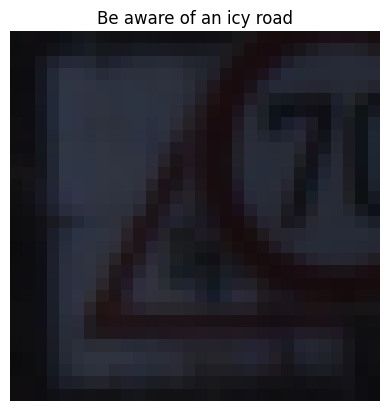

prediction set: {Narrows from right: 0.3830157220363617, Work in process: 0.2666560709476471, Be aware of an icy road: 0.180376335978508, Priority at upcoming crossing: 0.09350092709064484, Warning: 0.05110251158475876, Crosswalk: 0.012144122272729874, Must turn right: 0.005298809614032507, double curve - first to left: 0.0032394183799624443, Be aware of wild animals: 0.0027831122279167175, left turn: 0.0005891447071917355, Must turn left: 0.0005541375721804798, Drive from the right side of the obstacle: 0.00032619546982459724, 30 km/h: 0.00010590459714876488, Priotrity road starts: 0.00010073983867187053, Traffic cirlce: 7.210503827081993e-05}


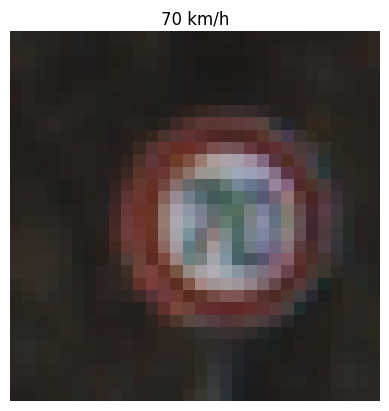

prediction set: {70 km/h: 0.9800973534584045, 120 km/h: 0.019902629777789116}


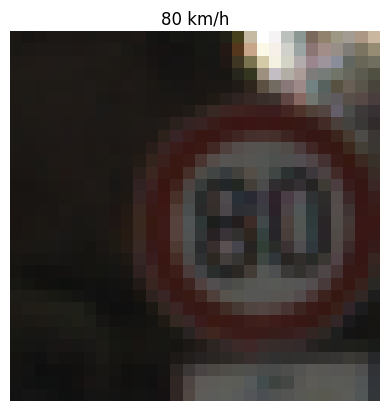

prediction set: {70 km/h: 0.7057514190673828, 100 km/h: 0.1598181277513504, 120 km/h: 0.059898629784584045, 30 km/h: 0.03250463679432869, 50 km/h: 0.018032677471637726, 20 km/h: 0.009892425499856472, 80 km/h: 0.009045863524079323, No Passing for vehicles over 3.5t: 0.0016259703552350402, No entry: 0.001373019302263856, Do not enter: 0.0007996970671229064, Priority at upcoming crossing: 0.0005860257078893483, Priotrity road starts: 0.00021303899120539427, Traffic signal: 0.00012062190944561735, Traffic cirlce: 0.0001070112339220941, Stop: 8.643979526823387e-05, Drive from the left side of the obstacle: 4.146481296629645e-05}


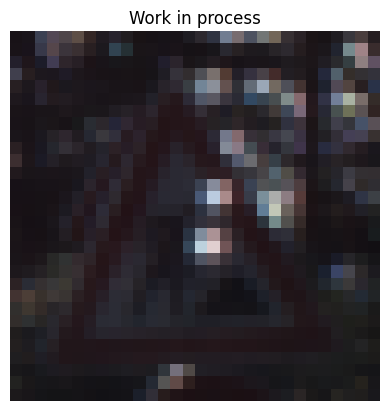

prediction set: {50 km/h: 0.7915395498275757, 80 km/h: 0.19729575514793396, left turn: 0.005211978685110807, 60 km/h: 0.004590632859617472, Be aware of wild animals: 0.0007249425980262458, No Passing for vehicles over 3.5t: 0.0006281689857132733}


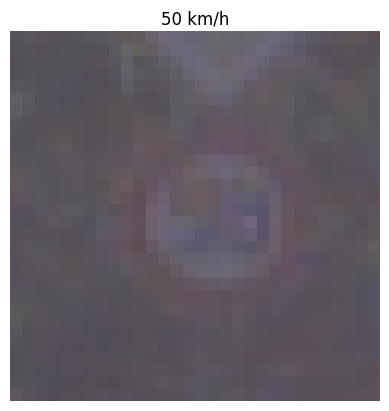

prediction set: {70 km/h: 0.8073288798332214, 30 km/h: 0.1908164769411087, 50 km/h: 0.0017577544786036015, No entry: 7.538175123045221e-05}


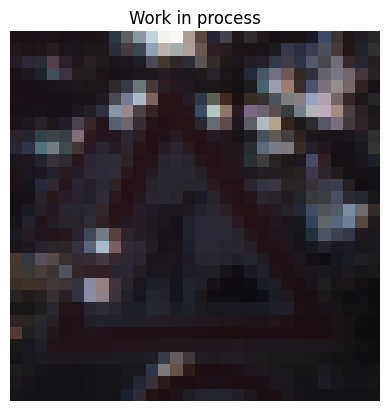

prediction set: {30 km/h: 0.5908194780349731, 70 km/h: 0.17799916863441467, Work in process: 0.1750681847333908, Do not enter: 0.02198847010731697, Rough road: 0.008945759385824203, No entry: 0.006425408646464348, Traffic signal: 0.004972807597368956, 50 km/h: 0.004427287261933088, yield right-of-way: 0.004239087458699942, Priotrity road starts: 0.001962697133421898, 20 km/h: 0.0012986164074391127, Warning: 0.0012566694058477879, Drive from the right side of the obstacle: 0.00027637172024697065, Must go straight or turn right: 0.00022583836107514799, Be aware of wild animals: 7.198844832601026e-05}


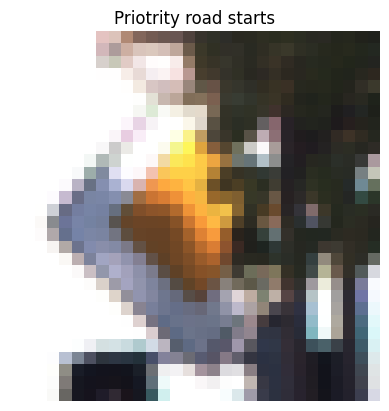

prediction set: {yield right-of-way: 0.9997647404670715, Priotrity road starts: 0.00021756421483587474}


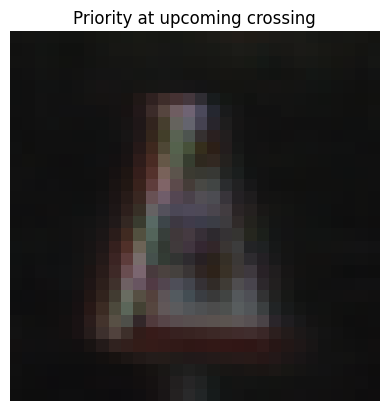

prediction set: {Be aware of an icy road: 0.6957745552062988, Slippery road: 0.25718116760253906, Work in process: 0.01545858196914196, Be aware of wild animals: 0.009785369969904423, Be aware of cyclists: 0.005464640446007252, left turn: 0.004532990977168083, right turn: 0.0035984928254038095, Priority at upcoming crossing: 0.003451587399467826, Narrows from right: 0.0013352768728509545, Must turn left: 0.0008447088184766471, Priotrity road starts: 0.0007494611782021821, double curve - first to left: 0.0006254265899769962, 80 km/h: 0.00027481053257361054, No Passing for vehicles over 3.5t: 0.00025640835519880056, End of no passing for vehicles over 3.5t: 0.00022058926697354764, Be aware of children: 0.0001280352589674294, 60 km/h: 9.32204129640013e-05, Traffic signal: 5.811523078591563e-05, No Passing: 4.0689421439310536e-05}


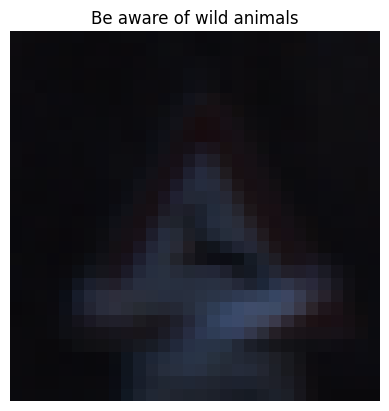

prediction set: {Slippery road: 0.8938606977462769, left turn: 0.1008475199341774, Be aware of wild animals: 0.003068918129429221, 80 km/h: 0.000916792603675276, 60 km/h: 0.0005177179700694978, Must turn left: 0.00035177081008441746, No Passing for vehicles over 3.5t: 0.00027615757426247, double curve - first to left: 5.9913229051744565e-05, End of 80 km/h: 4.939456266583875e-05}


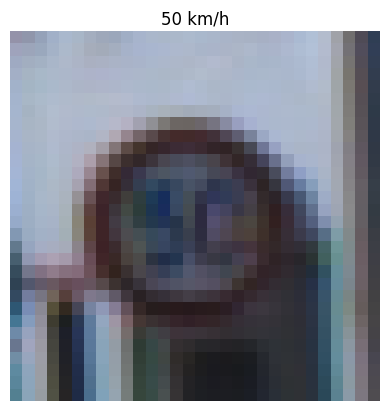

prediction set: {120 km/h: 0.6138961315155029, 80 km/h: 0.3790665864944458, 100 km/h: 0.007017284631729126}


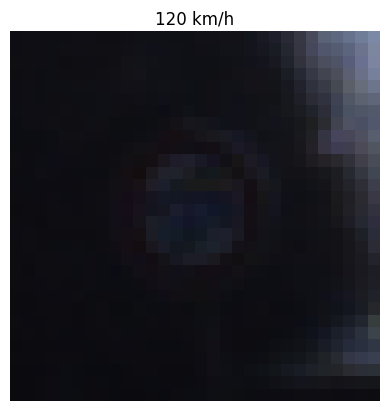

prediction set: {No entry: 0.6373264789581299, 120 km/h: 0.16933178901672363, right turn: 0.0841367244720459, Be aware of children: 0.06853894889354706, 60 km/h: 0.02925155498087406, Rough road: 0.003970925230532885, Warning: 0.0020295113790780306, yield right-of-way: 0.0012631826102733612, 80 km/h: 0.0010664376895874739, Must go straight or turn right: 0.0008803142700344324, No entry for vehicles over 3.5t: 0.0005733908619731665, 20 km/h: 0.0005390175501815975, No Passing: 0.00041420134948566556, Must go straight: 0.00024493213277310133, Stop: 0.0001505231048213318, Work in process: 6.951590330572799e-05, Be aware of cyclists: 5.679775131284259e-05, Must go straight or turn left: 4.576004357659258e-05, Must turn right: 4.5186523493612185e-05}


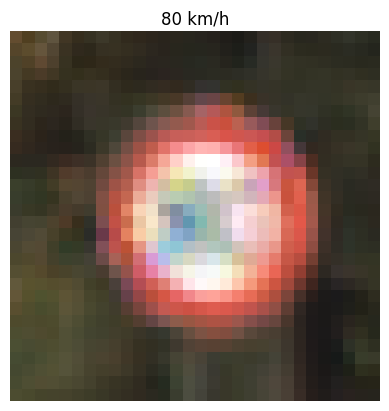

prediction set: {60 km/h: 0.9264816045761108, 80 km/h: 0.03709564730525017, 50 km/h: 0.03642275929450989}


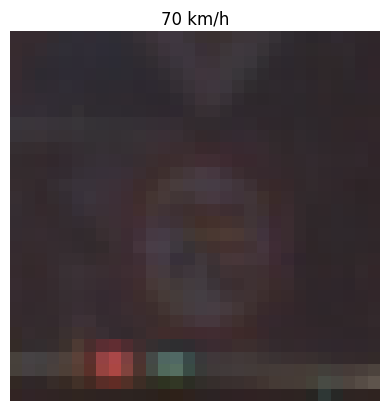

prediction set: {70 km/h: 0.6367497444152832, 30 km/h: 0.2360483855009079, Warning: 0.06345747411251068, Be aware of wild animals: 0.030298858880996704, 50 km/h: 0.016431469470262527, Traffic signal: 0.005539780016988516, 20 km/h: 0.004513276740908623, No entry: 0.001969396835193038, 80 km/h: 0.001641115639358759, double curve - first to left: 0.001166686648502946, Do not enter: 0.0004320521547924727, Work in process: 0.0003423072339501232, End of 80 km/h: 0.0002684446517378092, Must turn right: 0.00022097033797763288, End of speed limit: 0.00021459869458340108, Must go straight or turn left: 0.0001615120272617787, Priority at upcoming crossing: 0.00015208532568067312, 100 km/h: 0.00012806722952518612, Drive from the left side of the obstacle: 8.346449612872675e-05, 120 km/h: 5.0356586143607274e-05, Crosswalk: 4.279626227798872e-05}


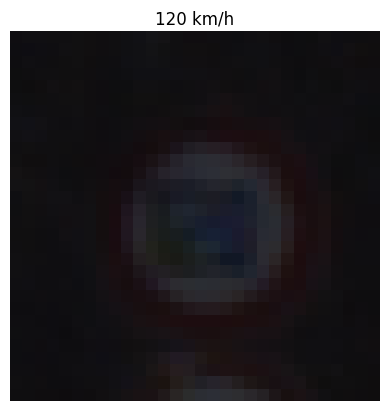

prediction set: {100 km/h: 0.9957872033119202, 80 km/h: 0.004150025080889463, No Passing for vehicles over 3.5t: 5.985772077110596e-05}


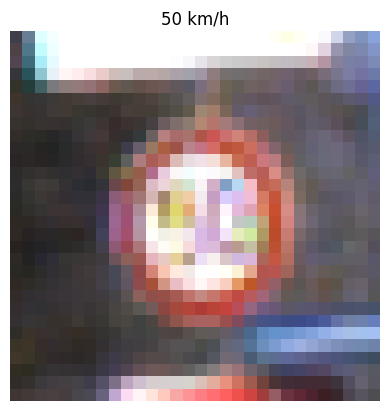

prediction set: {70 km/h: 0.999592125415802, 50 km/h: 0.00037528426037169993}


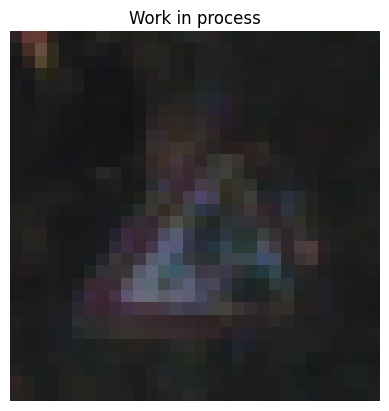

prediction set: {Work in process: 0.609497606754303, double curve - first to left: 0.18742957711219788, Be aware of wild animals: 0.13566577434539795, Priority at upcoming crossing: 0.030152859166264534, Do not enter: 0.014780588448047638, 30 km/h: 0.005119453649967909, Be aware of an icy road: 0.004149170592427254, Traffic signal: 0.0032333885319530964, Priotrity road starts: 0.002870192751288414, Narrows from right: 0.0028066756203770638, Warning: 0.0013799554435536265, Crosswalk: 0.000828924123197794, Drive from the right side of the obstacle: 0.0006112484843470156, 20 km/h: 0.0005484952125698328, right turn: 0.0004363326879683882, left turn: 0.00025527458637952805, 70 km/h: 0.00012873981904704124, End of 80 km/h: 4.143632031627931e-05}


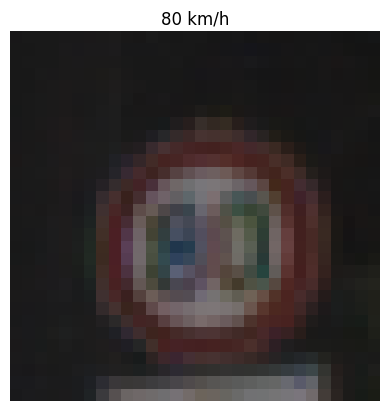

prediction set: {80 km/h: 0.9996788501739502, 60 km/h: 0.00032121414551511407}


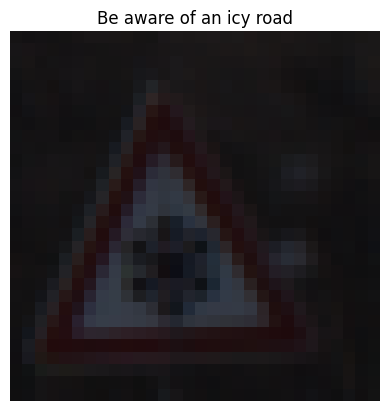

prediction set: {Be aware of an icy road: 0.3020016849040985, Be aware of wild animals: 0.17553366720676422, Work in process: 0.14051884412765503, Narrows from right: 0.06497730314731598, Be aware of cyclists: 0.055641889572143555, right turn: 0.04950200393795967, left turn: 0.043700408190488815, Slippery road: 0.03544936329126358, double curve - first to left: 0.02570863626897335, Priority at upcoming crossing: 0.025222521275281906, Warning: 0.012937645427882671, Traffic signal: 0.011162285692989826, 80 km/h: 0.00955091044306755, Stop: 0.005523270461708307, Priotrity road starts: 0.00544712832197547, Do not enter: 0.004784066695719957, 20 km/h: 0.004762215074151754, No Passing for vehicles over 3.5t: 0.0033873298671096563, 30 km/h: 0.0032474633771926165, Crosswalk: 0.0025764652527868748, 60 km/h: 0.002251751022413373, Drive from the right side of the obstacle: 0.001990052405744791, Must turn left: 0.0019049558322876692, Rough road: 0.001747263129800558, 50 km/h: 0.001625820412300527, 

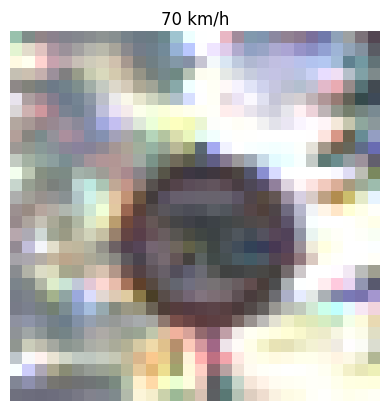

prediction set: {80 km/h: 0.9991399049758911, 70 km/h: 0.0008569498895667493}


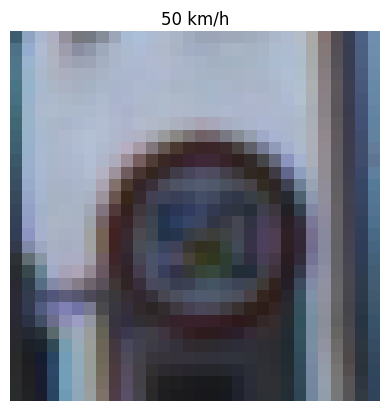

prediction set: {80 km/h: 0.9347555041313171, 60 km/h: 0.06167418882250786, No Passing for vehicles over 3.5t: 0.003078032750636339, Slippery road: 0.0004896033206023276}


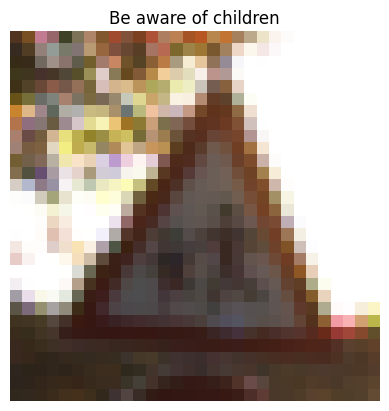

prediction set: {Be aware of children: 0.7665504217147827, Be aware of cyclists: 0.21913519501686096, Rough road: 0.014148324728012085, right turn: 0.00010485997336218134, Stop: 6.00614512222819e-05}


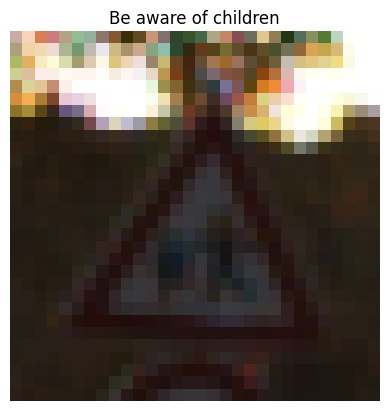

prediction set: {Be aware of an icy road: 0.5117084383964539, Be aware of children: 0.4817543029785156, Slippery road: 0.004531998187303543, No Passing: 0.0009744439157657325, right turn: 0.0007022067438811064, 60 km/h: 0.0001841624907683581, Be aware of cyclists: 4.4505759433377534e-05, Narrows from right: 4.024612280772999e-05}


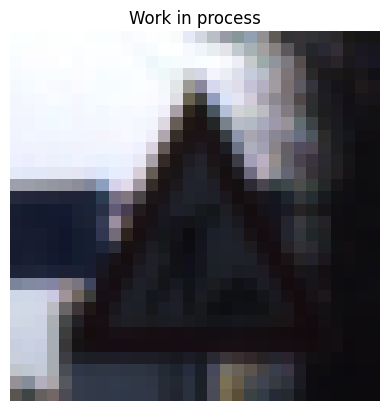

prediction set: {Priority at upcoming crossing: 0.6283863186836243, Be aware of an icy road: 0.26870694756507874, Crosswalk: 0.08906488865613937, Narrows from right: 0.0056914519518613815, Work in process: 0.004826102871447802, Must turn right: 0.001658539636991918, double curve - first to left: 0.0007692926446907222, Must turn left: 0.00024388148449361324, Warning: 0.000163025499205105, 30 km/h: 0.00014686357462778687, No entry for vehicles over 3.5t: 0.00012077938299626112, Drive from the right side of the obstacle: 8.712056296644732e-05, Be aware of wild animals: 7.048129918985069e-05}


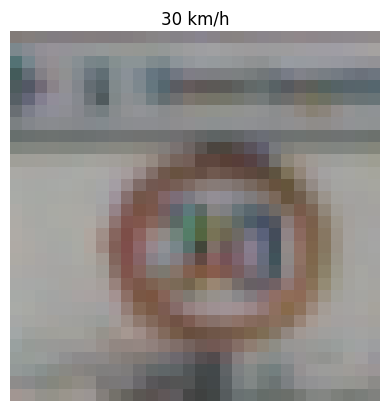

prediction set: {50 km/h: 0.9573138356208801, 30 km/h: 0.04106931760907173, Stop: 0.0014404990943148732, 80 km/h: 0.0001410704426234588}


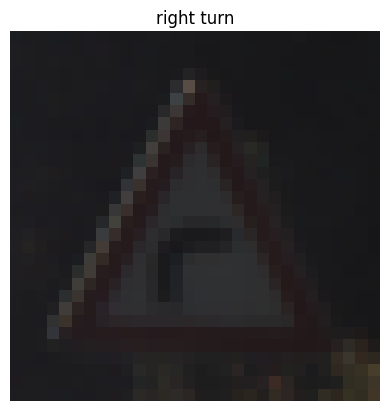

prediction set: {Slippery road: 0.3521701395511627, right turn: 0.32003864645957947, 60 km/h: 0.09483521431684494, No Passing for vehicles over 3.5t: 0.08262348175048828, No Passing: 0.06364226341247559, Must go straight: 0.05094007030129433, No entry for vehicles over 3.5t: 0.020211687311530113, 80 km/h: 0.011663686484098434, End of no passing for vehicles over 3.5t: 0.003457160433754325, 100 km/h: 0.00020055813365615904, Must turn left: 0.00011636269482551143, End of no passing: 5.7602501328801736e-05}


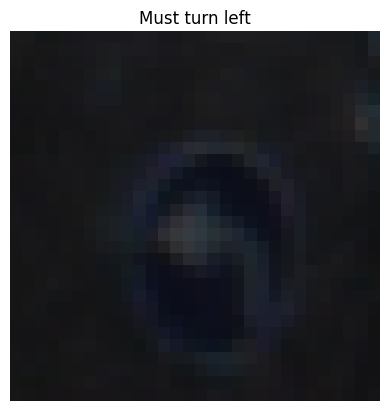

prediction set: {Traffic cirlce: 0.3056199550628662, Must go straight: 0.29325205087661743, End of 80 km/h: 0.18489514291286469, Must turn left: 0.12726376950740814, End of speed limit: 0.029193352907896042, End of no passing: 0.02675723284482956, End of no passing for vehicles over 3.5t: 0.017104724422097206, Priority at upcoming crossing: 0.00798307079821825, Drive from the left side of the obstacle: 0.00230276957154274, No entry for vehicles over 3.5t: 0.0015702220844104886, 30 km/h: 0.0010986317647621036, Priotrity road starts: 0.0007693194202147424, Must go straight or turn left: 0.0005746665992774069, Be aware of an icy road: 0.0004440908378455788, Drive from the right side of the obstacle: 0.0004281192668713629, Must turn right: 0.00034731277264654636, Must go straight or turn right: 0.00016019634495023638, double curve - first to left: 9.992490959120914e-05, Be aware of children: 7.020592602202669e-05}


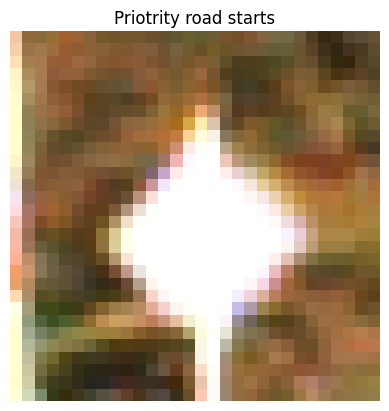

prediction set: {No entry: 0.6972255706787109, Priotrity road starts: 0.2973901331424713, yield right-of-way: 0.005199736915528774, End of speed limit: 0.00017082034901250154}


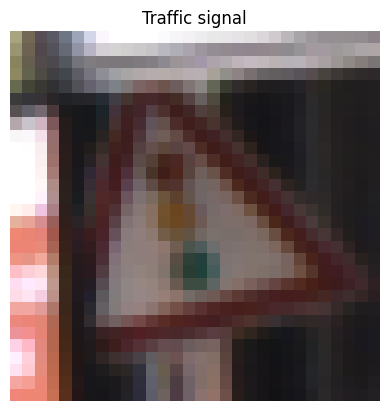

prediction set: {Warning: 0.6248395442962646, Traffic signal: 0.37514564394950867}


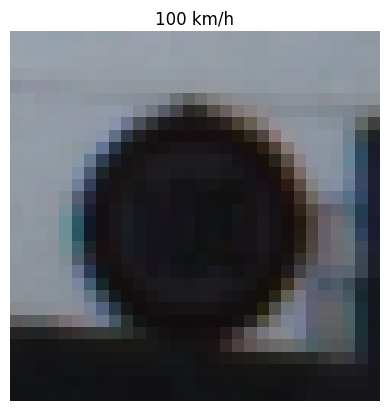

prediction set: {120 km/h: 0.6097046732902527, 100 km/h: 0.37671226263046265, 80 km/h: 0.013577169738709927}


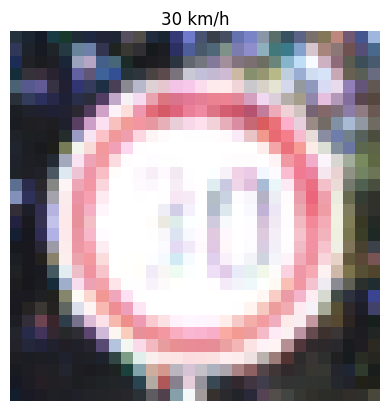

prediction set: {30 km/h: 0.9977681636810303, 70 km/h: 0.0012871199287474155, 20 km/h: 0.000785432814154774, No entry: 0.00015444761083927006}


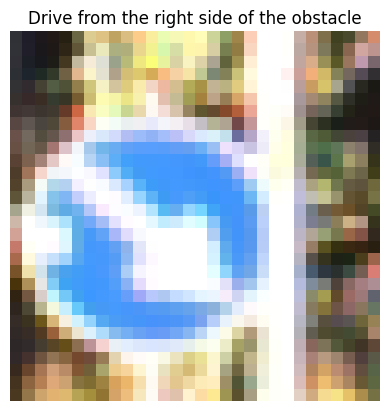

prediction set: {Drive from the left side of the obstacle: 1.0}


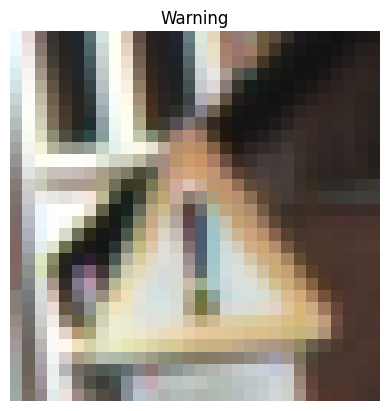

prediction set: {Must turn right: 0.9909170269966125, Drive from the left side of the obstacle: 0.0033497216645628214, Must go straight or turn left: 0.0029658484272658825, Traffic cirlce: 0.0021722037345170975, Must go straight: 0.00019989449356216937, Warning: 0.00011598013952607289, Drive from the right side of the obstacle: 8.818340575089678e-05, Must turn left: 7.055325113469735e-05, Be aware of children: 4.3456402636365965e-05}


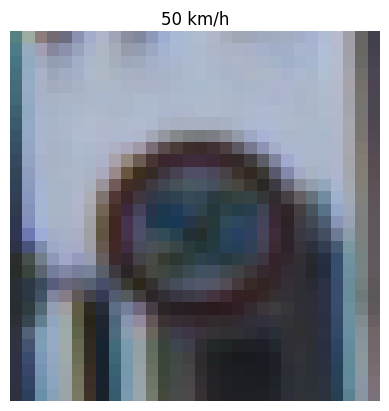

prediction set: {80 km/h: 0.5486776232719421, End of 80 km/h: 0.3329402804374695, No entry for vehicles over 3.5t: 0.0871787890791893, End of speed limit: 0.011279222555458546, No Passing for vehicles over 3.5t: 0.00921341311186552, 100 km/h: 0.004446573555469513, End of no passing: 0.00410529226064682, End of no passing for vehicles over 3.5t: 0.0017022034153342247, 60 km/h: 0.00035044236574321985, No Passing: 0.00010311218647984788}


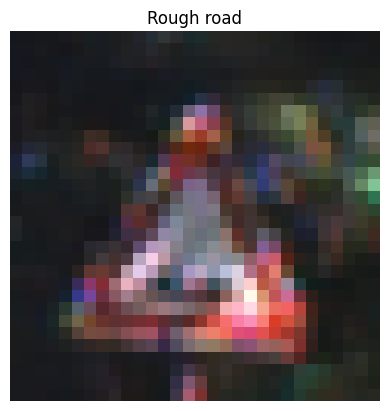

prediction set: {Warning: 0.3698157072067261, Traffic signal: 0.2528039216995239, Rough road: 0.17973025143146515, Be aware of cyclists: 0.14964547753334045, Narrows from right: 0.027437398210167885, Work in process: 0.009820171631872654, Stop: 0.0064940862357616425, Be aware of children: 0.0012460186844691634, Crosswalk: 0.0008970479248091578, No entry: 0.0007102708914317191, 20 km/h: 0.0004917935002595186, right turn: 0.0003878489078488201, Do not enter: 0.0002943525032605976, Must go straight or turn right: 0.00017491652397438884, 70 km/h: 5.026687358622439e-05}


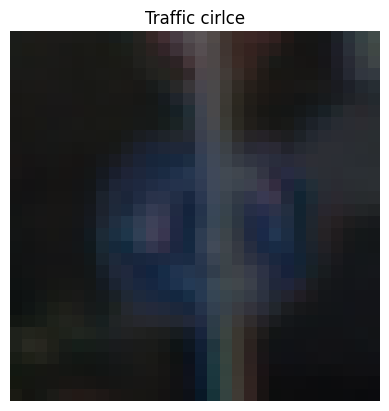

prediction set: {Must go straight or turn left: 0.8307047486305237, Drive from the left side of the obstacle: 0.13073067367076874, Traffic cirlce: 0.025606859475374222, End of 80 km/h: 0.007788002025336027, Must go straight: 0.004871829878538847, Warning: 0.00018478526908438653, Must turn right: 7.067742990329862e-05}


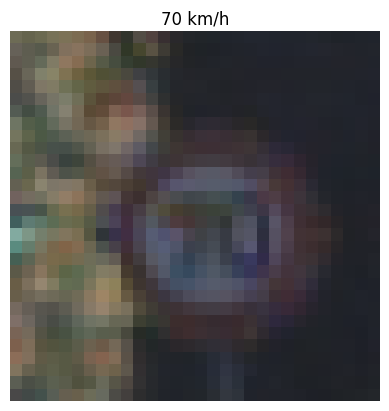

prediction set: {30 km/h: 0.6338750123977661, 50 km/h: 0.22445885837078094, 70 km/h: 0.1370389461517334, Do not enter: 0.0036303619854152203, Priotrity road starts: 0.0004040760104544461, End of 80 km/h: 0.0002739708579611033, 20 km/h: 0.00023723758931737393, No entry: 4.1930466977646574e-05}


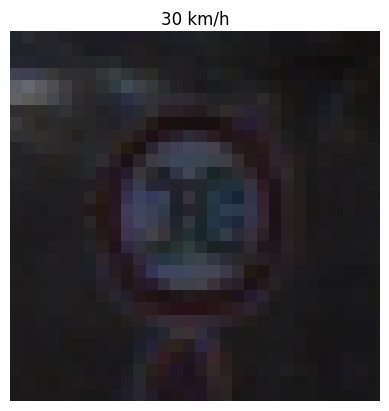

prediction set: {30 km/h: 0.9999523162841797, 70 km/h: 4.354828342911787e-05}


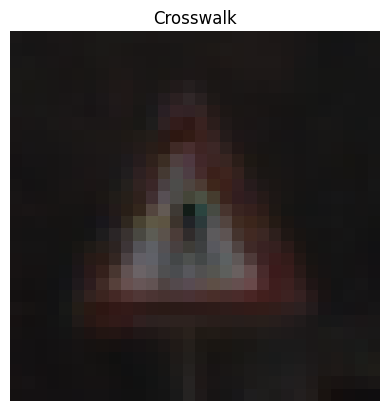

prediction set: {100 km/h: 0.5414939522743225, Crosswalk: 0.2773069441318512, Priority at upcoming crossing: 0.06943409144878387, Traffic cirlce: 0.06628219783306122, Warning: 0.021313145756721497, Must go straight or turn left: 0.012298661284148693, Narrows from right: 0.00838507805019617, No entry for vehicles over 3.5t: 0.001820034347474575, 120 km/h: 0.0010417902376502752, 30 km/h: 0.0003303858684375882, 20 km/h: 0.00013409579696599394, End of no passing for vehicles over 3.5t: 8.928133320296183e-05, Must turn right: 4.509360223892145e-05}


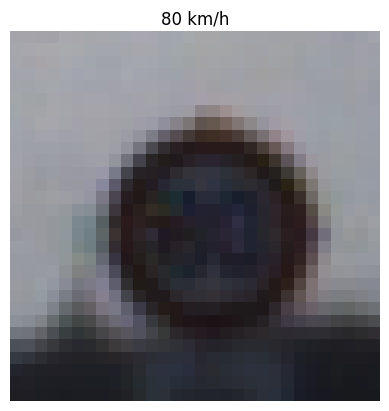

prediction set: {No Passing for vehicles over 3.5t: 0.9950163960456848, 60 km/h: 0.003527681343257427, 80 km/h: 0.0013794382102787495, 50 km/h: 7.504611858166754e-05}


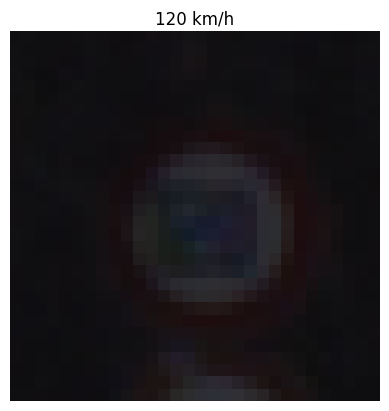

prediction set: {100 km/h: 0.9870800375938416, 120 km/h: 0.010748635046184063, 80 km/h: 0.0015750185120850801, No entry for vehicles over 3.5t: 0.0002787126286420971, No Passing for vehicles over 3.5t: 0.0002672560513019562}


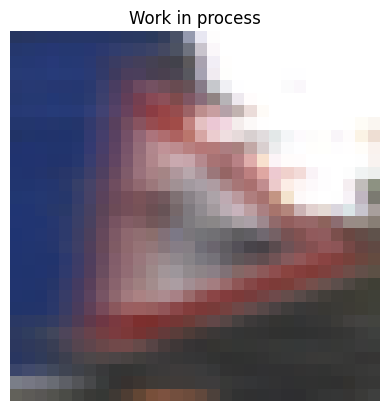

prediction set: {Be aware of wild animals: 0.6937829256057739, 50 km/h: 0.09383879601955414, 80 km/h: 0.05112765356898308, 70 km/h: 0.03985494747757912, Drive from the right side of the obstacle: 0.039468999952077866, right turn: 0.019746951758861542, 30 km/h: 0.015633324161171913, No Passing for vehicles over 3.5t: 0.01411200501024723, Work in process: 0.013928504660725594, End of 80 km/h: 0.0071449377574026585, left turn: 0.004541464149951935, double curve - first to left: 0.001996068051084876, Do not enter: 0.0017601570580154657, Drive from the left side of the obstacle: 0.0006548480014316738, Traffic signal: 0.00044742863974533975, Priotrity road starts: 0.0003797810059040785, Rough road: 0.00034453411353752017, 60 km/h: 0.0002402716054348275, Warning: 0.00020563616999424994, yield right-of-way: 0.00017495859356131405, 100 km/h: 0.0001313534885412082, 120 km/h: 0.00010634966020006686, 20 km/h: 7.652732892893255e-05, Must go straight or turn left: 6.942242907825857e-05, Traffic cirl

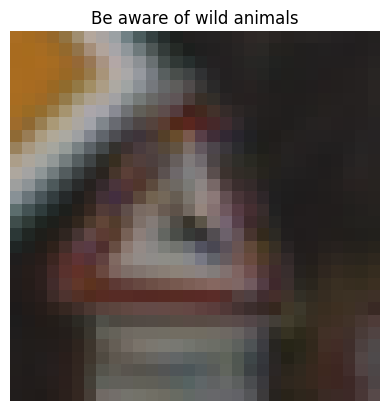

prediction set: {Be aware of wild animals: 0.470505028963089, No Passing for vehicles over 3.5t: 0.2720239460468292, 50 km/h: 0.2304462045431137, yield right-of-way: 0.015886982902884483, Stop: 0.005468118004500866, Work in process: 0.002664505736902356, 80 km/h: 0.0025052614510059357, Drive from the right side of the obstacle: 0.00023578257241752, Do not enter: 0.00016005018551368266, 60 km/h: 0.00010359044972574338}


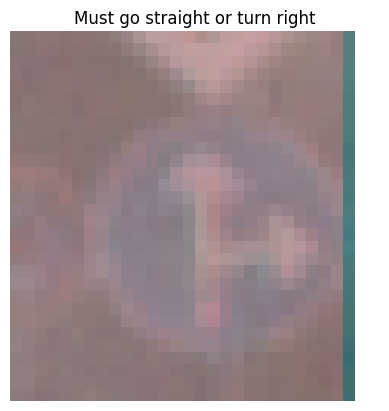

prediction set: {yield right-of-way: 0.48136013746261597, No Passing: 0.2182517647743225, 60 km/h: 0.1312958300113678, right turn: 0.054924000054597855, Must go straight or turn right: 0.03122950717806816, No entry: 0.02453041262924671, No Passing for vehicles over 3.5t: 0.024497631937265396, Must go straight: 0.017203908413648605, Priotrity road starts: 0.008140843361616135, End of no passing: 0.0022674177307635546, 80 km/h: 0.0014641002053394914, 50 km/h: 0.0014065565774217248, Rough road: 0.0010099154897034168, Drive from the right side of the obstacle: 0.0008392151212319732, End of speed limit: 0.00048184397746808827, Do not enter: 0.00017330360424239188, Must turn right: 0.00017124273290392011, Stop: 0.00014671323879156262, Drive from the left side of the obstacle: 0.00013997688074596226, No entry for vehicles over 3.5t: 0.00013044540537521243, Work in process: 9.323225094703957e-05, Be aware of children: 8.297009480884299e-05, 120 km/h: 8.035397331696004e-05}


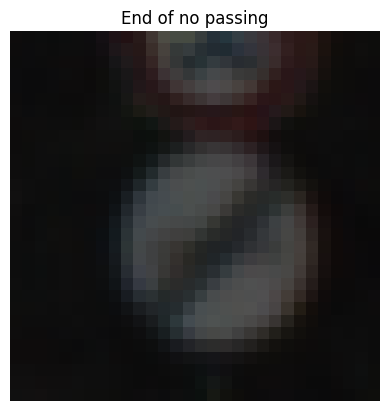

prediction set: {Be aware of children: 0.7871241569519043, End of no passing: 0.19890031218528748, No Passing: 0.006393414456397295, No entry for vehicles over 3.5t: 0.004425344057381153, Priority at upcoming crossing: 0.0018601027550175786, End of speed limit: 0.0008901087567210197, Must go straight: 0.0002302094508195296, Traffic cirlce: 0.00016537807823624462}


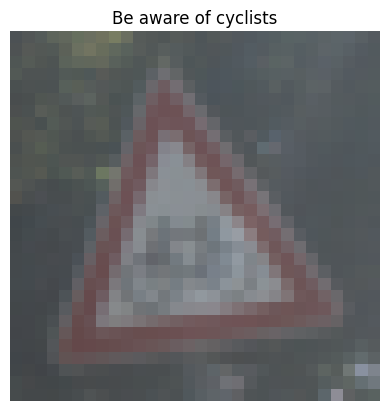

prediction set: {Be aware of children: 0.3712296485900879, Be aware of cyclists: 0.3594356179237366, Narrows from right: 0.1084018126130104, Be aware of an icy road: 0.09606370329856873, right turn: 0.03606487438082695, Slippery road: 0.016055990010499954, Rough road: 0.0063334619626402855, left turn: 0.004670619033277035, Work in process: 0.0007695435779169202, Crosswalk: 0.00045971834333613515, Priority at upcoming crossing: 0.00018482882296666503, yield right-of-way: 9.593765571480617e-05, Priotrity road starts: 7.995352643774822e-05}


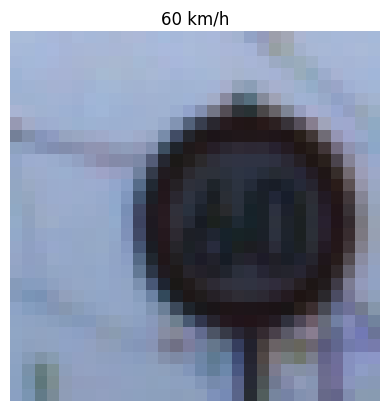

prediction set: {No entry for vehicles over 3.5t: 0.8463733196258545, No Passing: 0.12601932883262634, End of no passing: 0.02022900991141796, End of 80 km/h: 0.005620506592094898, End of speed limit: 0.0008675320423208177, 100 km/h: 0.00027154575218446553, 30 km/h: 0.00025240390095859766, End of no passing for vehicles over 3.5t: 0.00024731949088163674, No Passing for vehicles over 3.5t: 8.02582799224183e-05}


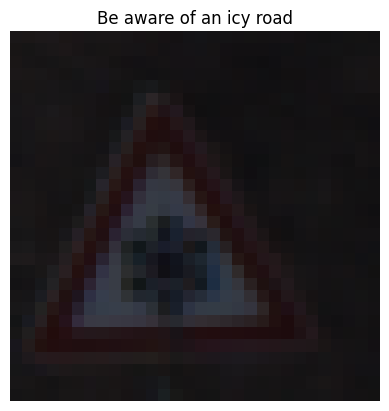

prediction set: {80 km/h: 0.6805832982063293, 60 km/h: 0.2901792824268341, No Passing for vehicles over 3.5t: 0.018303655087947845, End of 80 km/h: 0.004372507333755493, Must turn left: 0.002281795721501112, Slippery road: 0.0021300320513546467, Drive from the right side of the obstacle: 0.0009219349594786763, left turn: 0.0003413261438254267, 50 km/h: 0.0003283332916907966, Must go straight: 0.00025059771724045277, End of no passing for vehicles over 3.5t: 0.00011552703654160723, No entry for vehicles over 3.5t: 0.0001004596269922331, right turn: 4.9637303163763136e-05}


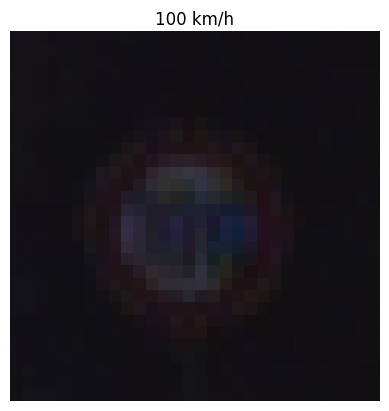

prediction set: {100 km/h: 0.49574580788612366, 80 km/h: 0.28352636098861694, 120 km/h: 0.21770913898944855, No entry for vehicles over 3.5t: 0.0022831931710243225, 60 km/h: 0.000578305684030056, No Passing for vehicles over 3.5t: 0.00011824107059510425}


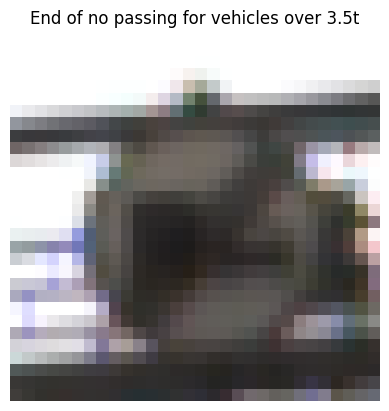

prediction set: {No Passing: 0.7831810116767883, No Passing for vehicles over 3.5t: 0.16840451955795288, End of no passing: 0.0219184011220932, Must go straight: 0.017785675823688507, 60 km/h: 0.008669130504131317}


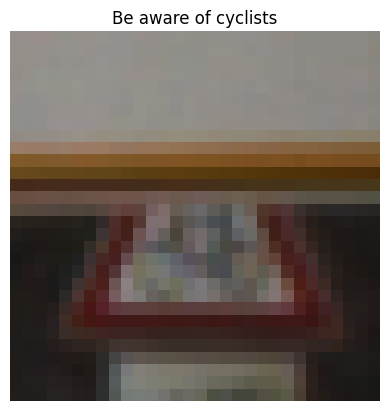

prediction set: {120 km/h: 0.40885481238365173, right turn: 0.3061676621437073, 80 km/h: 0.06495983898639679, 100 km/h: 0.04614902660250664, 70 km/h: 0.04021080210804939, Traffic signal: 0.031449150294065475, Warning: 0.01744999922811985, No entry for vehicles over 3.5t: 0.01695365086197853, Be aware of wild animals: 0.013780487701296806, Drive from the left side of the obstacle: 0.013675146736204624, Rough road: 0.010544111020863056, Must go straight or turn left: 0.006405455991625786, yield right-of-way: 0.004785068333148956, No Passing for vehicles over 3.5t: 0.003392240032553673, End of 80 km/h: 0.002248738892376423, Work in process: 0.001882221084088087, No entry: 0.0017682970501482487, 50 km/h: 0.001566700404509902, Drive from the right side of the obstacle: 0.0015058035496622324, left turn: 0.0013421080075204372, Be aware of an icy road: 0.0013107862323522568, Be aware of cyclists: 0.0011932521592825651, Traffic cirlce: 0.0010022384813055396, Priotrity road starts: 0.00046686665

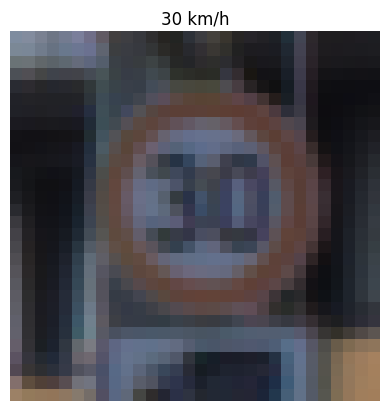

prediction set: {End of 80 km/h: 0.4552149474620819, End of no passing for vehicles over 3.5t: 0.3228779137134552, 80 km/h: 0.17143289744853973, 50 km/h: 0.033208057284355164, 100 km/h: 0.005535040516406298, Be aware of wild animals: 0.004460209049284458, 30 km/h: 0.003527124412357807, No entry for vehicles over 3.5t: 0.002881518565118313, 60 km/h: 0.00035258702700957656, left turn: 0.00025780629948712885, double curve - first to left: 0.0001471979048801586, No Passing for vehicles over 3.5t: 5.093227082397789e-05, Priority at upcoming crossing: 5.0664617447182536e-05}


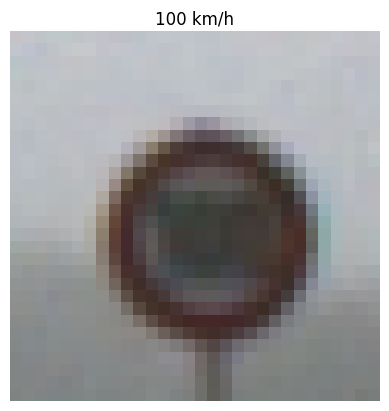

prediction set: {100 km/h: 0.9997401833534241, 120 km/h: 0.00025982377701438963}
_________________________________________________________________________________________
We have the probability of 0.8181818181818182 that the true label is in the prediction set with an average prediction set size of 9.854545454545455


In [ ]:
val_smx, _ = get_smx_and_labels(val_loader)
in_set_dist_critical, not_in_set_dist_critical = conformal_prediction(critical_points, valset, val_smx, show_img =  True, print_set = True)

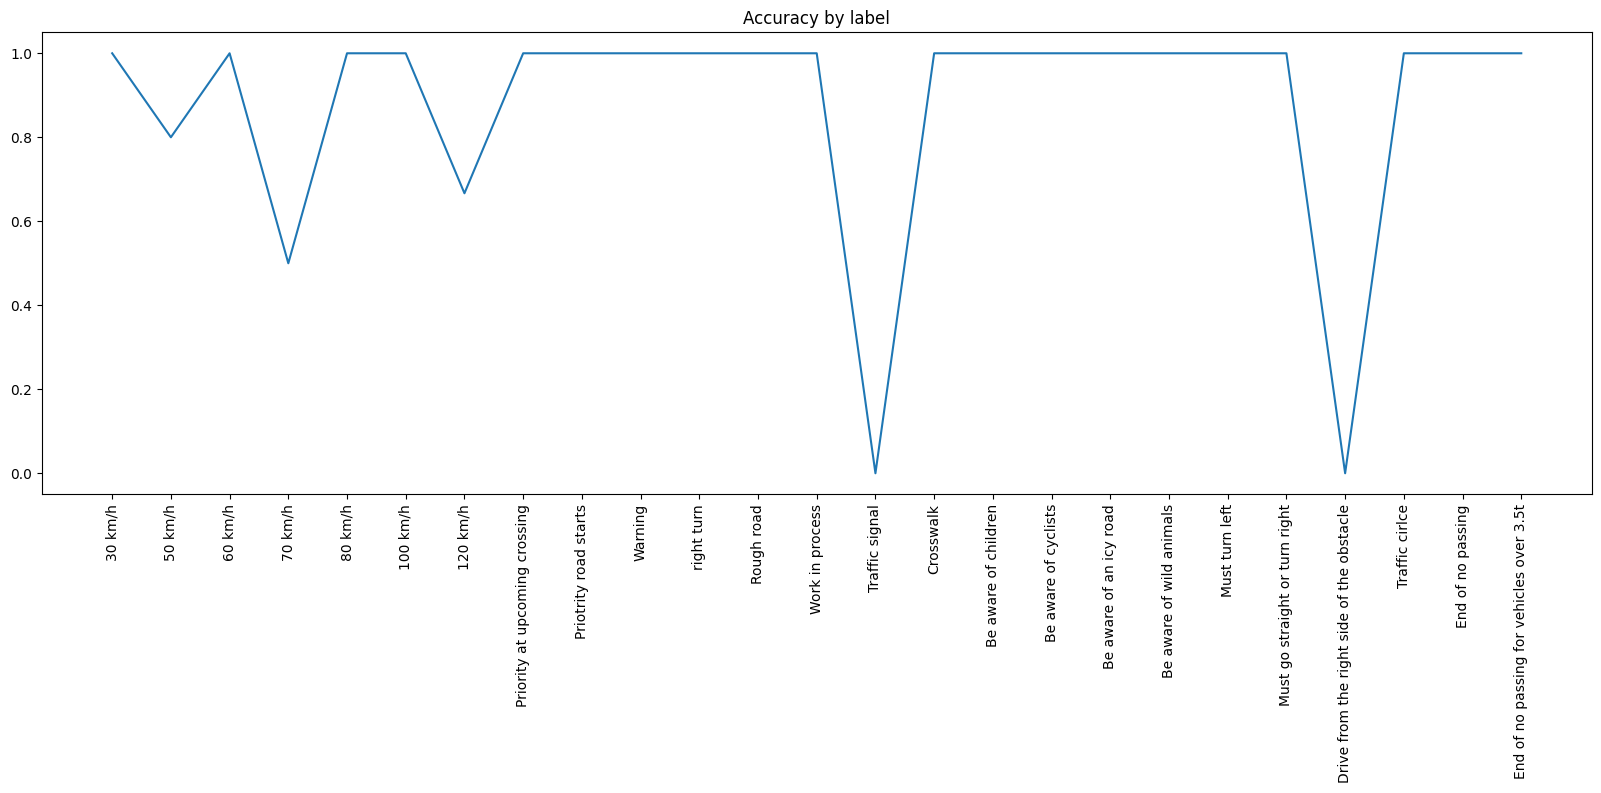

In [ ]:
val_set_critical = torch.utils.data.Subset(valset, indices = critical_points)
val_set_critical_loader = DataLoader(dataset = val_set_critical, batch_size = len(calset), shuffle = False)
val_critical_dist = get_distribution(val_set_critical_loader)
plot_relative_distribution(in_set_dist_critical, val_critical_dist, labels, "Accuracy by label")

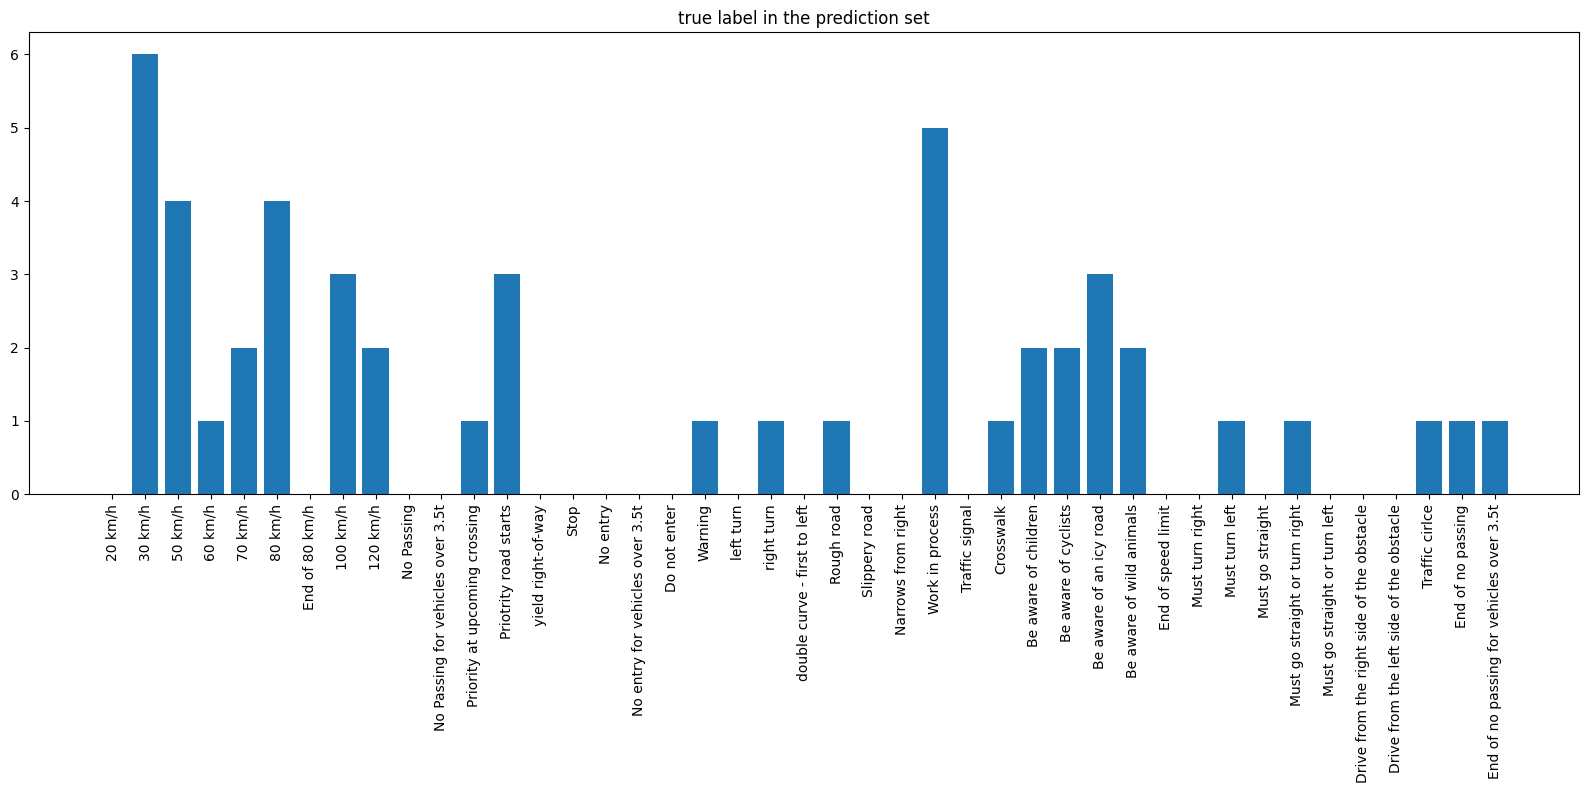

In [ ]:
plot_distribution(in_set_dist_critical, labels, "true label in the prediction set")

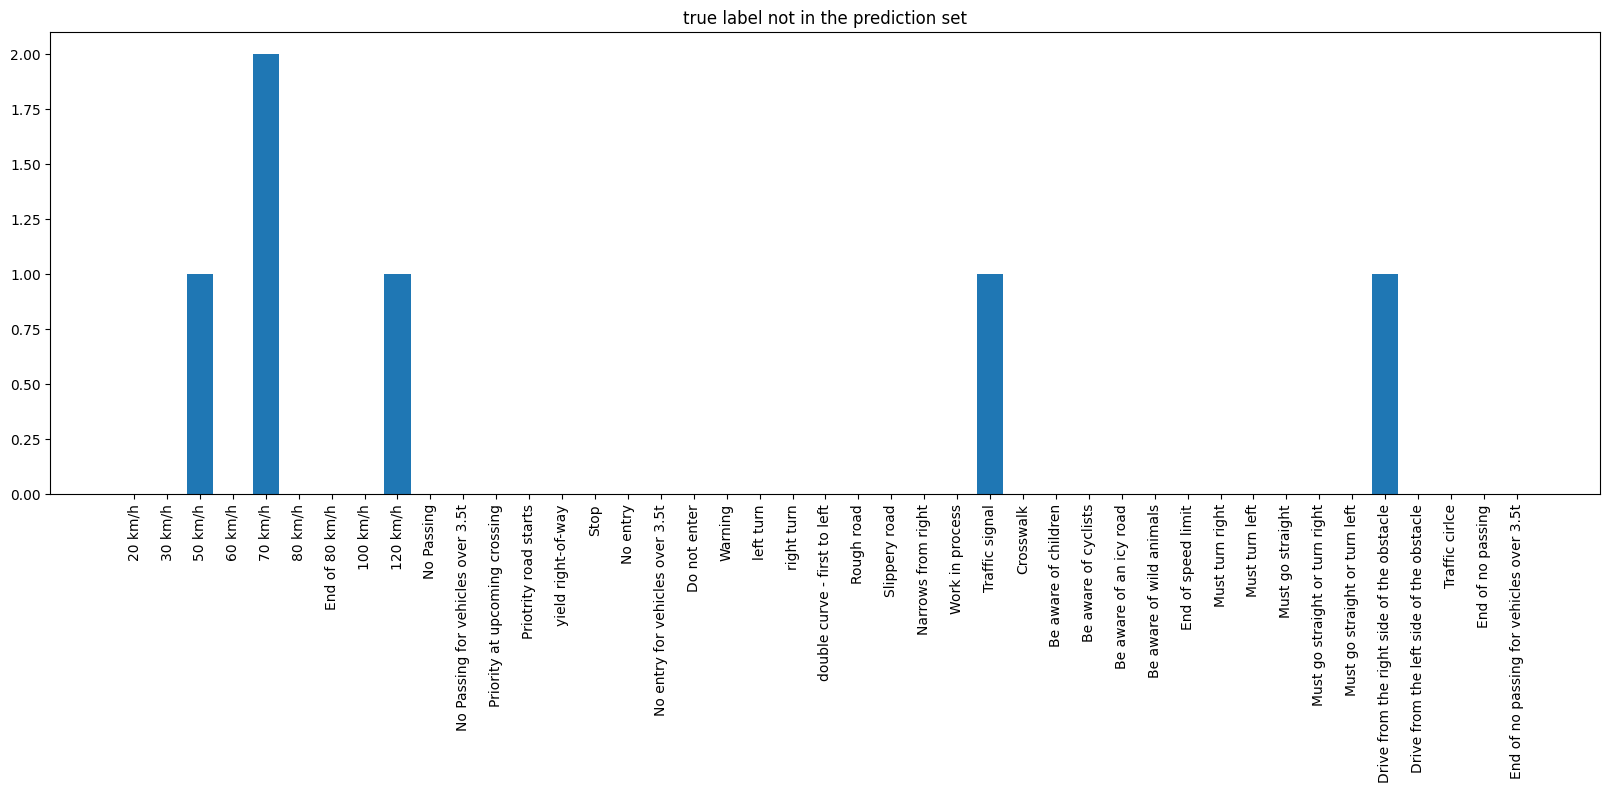

In [ ]:
plot_distribution(not_in_set_dist_critical, labels, "true label not in the prediction set")

# Conformal prediction for the whole validation set

In [ ]:
val_smx, _ = get_smx_and_labels(val_loader)
in_set_dist, not_in_set_dist = conformal_prediction(range(len(valset)), valset, val_smx, show_img = False, print_set = True)

Priotrity road starts                             prediction set: {End of no passing: 0.7557332515716553, End of speed limit: 0.22632081806659698, Be aware of children: 0.010179316624999046, End of no passing for vehicles over 3.5t: 0.0029132303316146135, Must turn left: 0.001555435941554606, Traffic cirlce: 0.0008738141041249037, No entry for vehicles over 3.5t: 0.0007484991219826043, Priotrity road starts: 0.0005010654567740858, No Passing: 0.00037651584716513753, Must turn right: 0.0003088679804932326, End of 80 km/h: 0.00028718021349050105, Be aware of an icy road: 7.537278725067154e-05, Priority at upcoming crossing: 5.871203393326141e-05, Must go straight: 4.9862715968629345e-05}
Slippery road                                     prediction set: {Slippery road: 0.9980296492576599, Narrows from right: 0.0013437136076390743, Be aware of an icy road: 0.0006000903085805476}
End of 80 km/h                                    prediction set: {End of 80 km/h: 0.9911137223243713, Traffic c

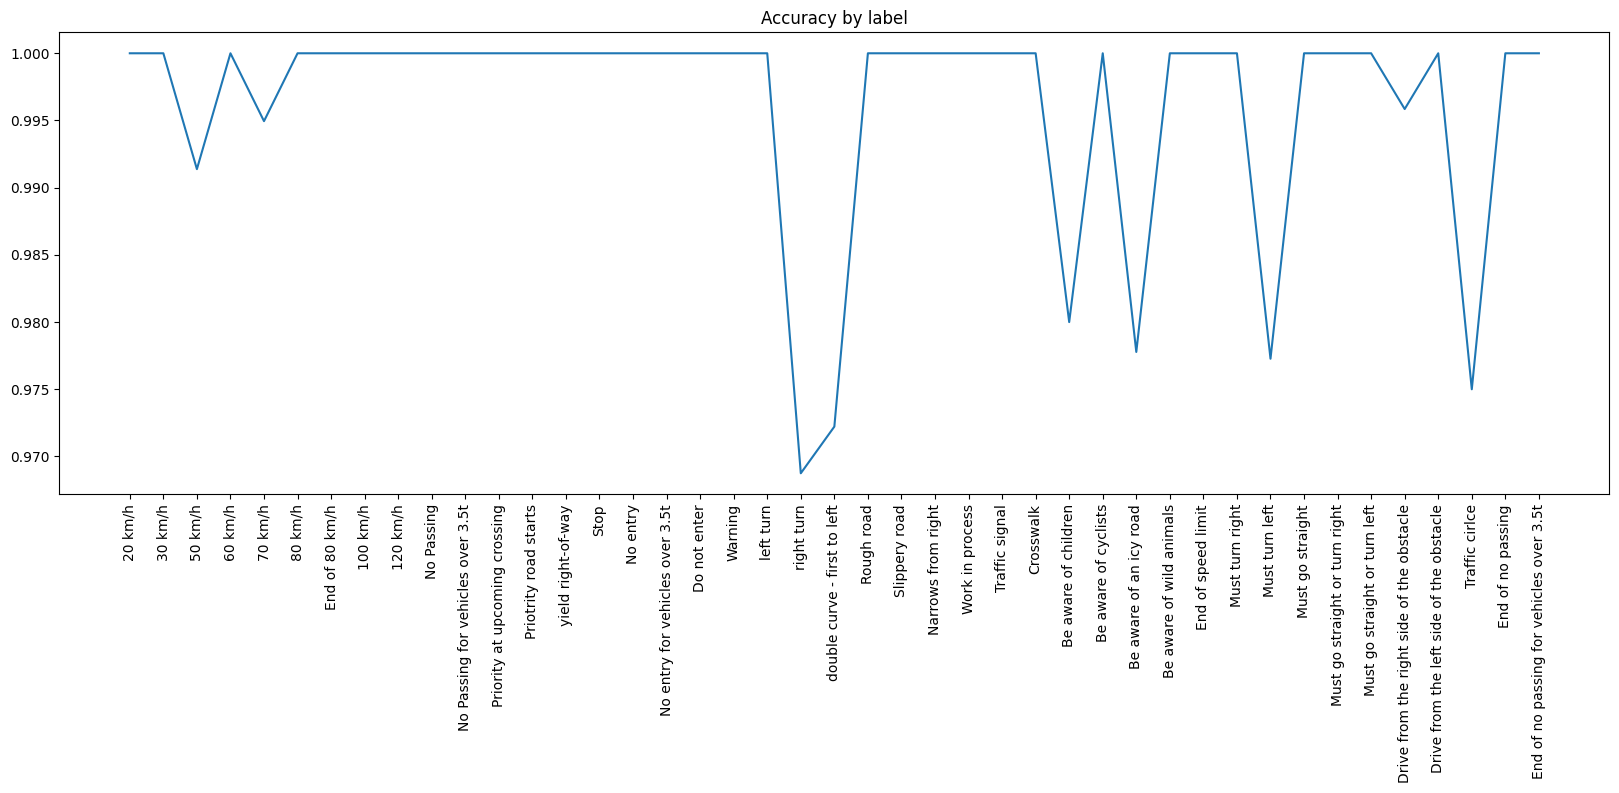

In [ ]:
plot_relative_distribution(in_set_dist, val_dist, labels, "Accuracy by label")

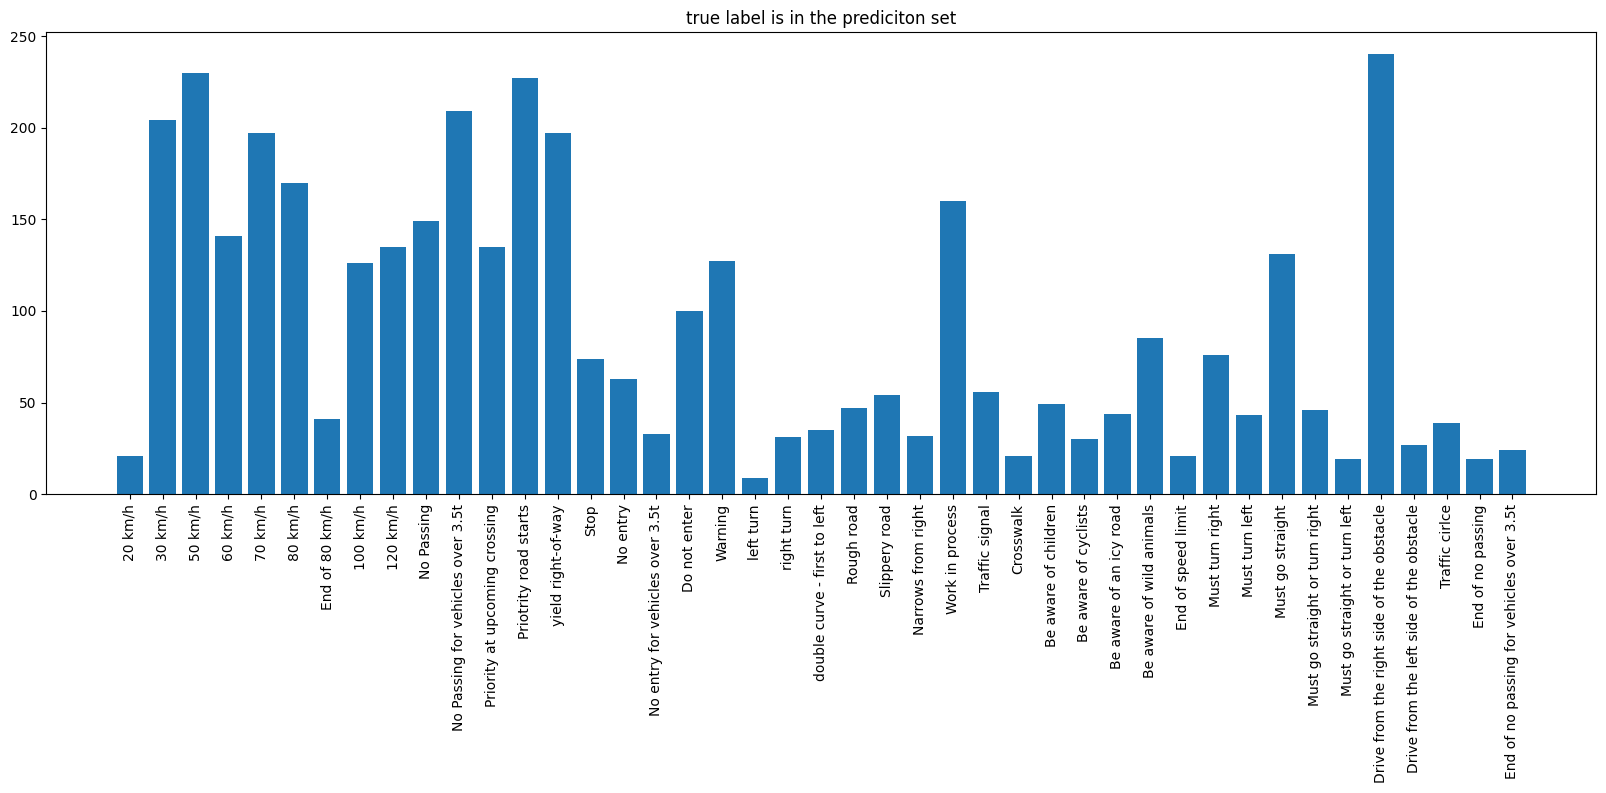

In [ ]:
plot_distribution(in_set_dist, labels, "true label is in the prediciton set")

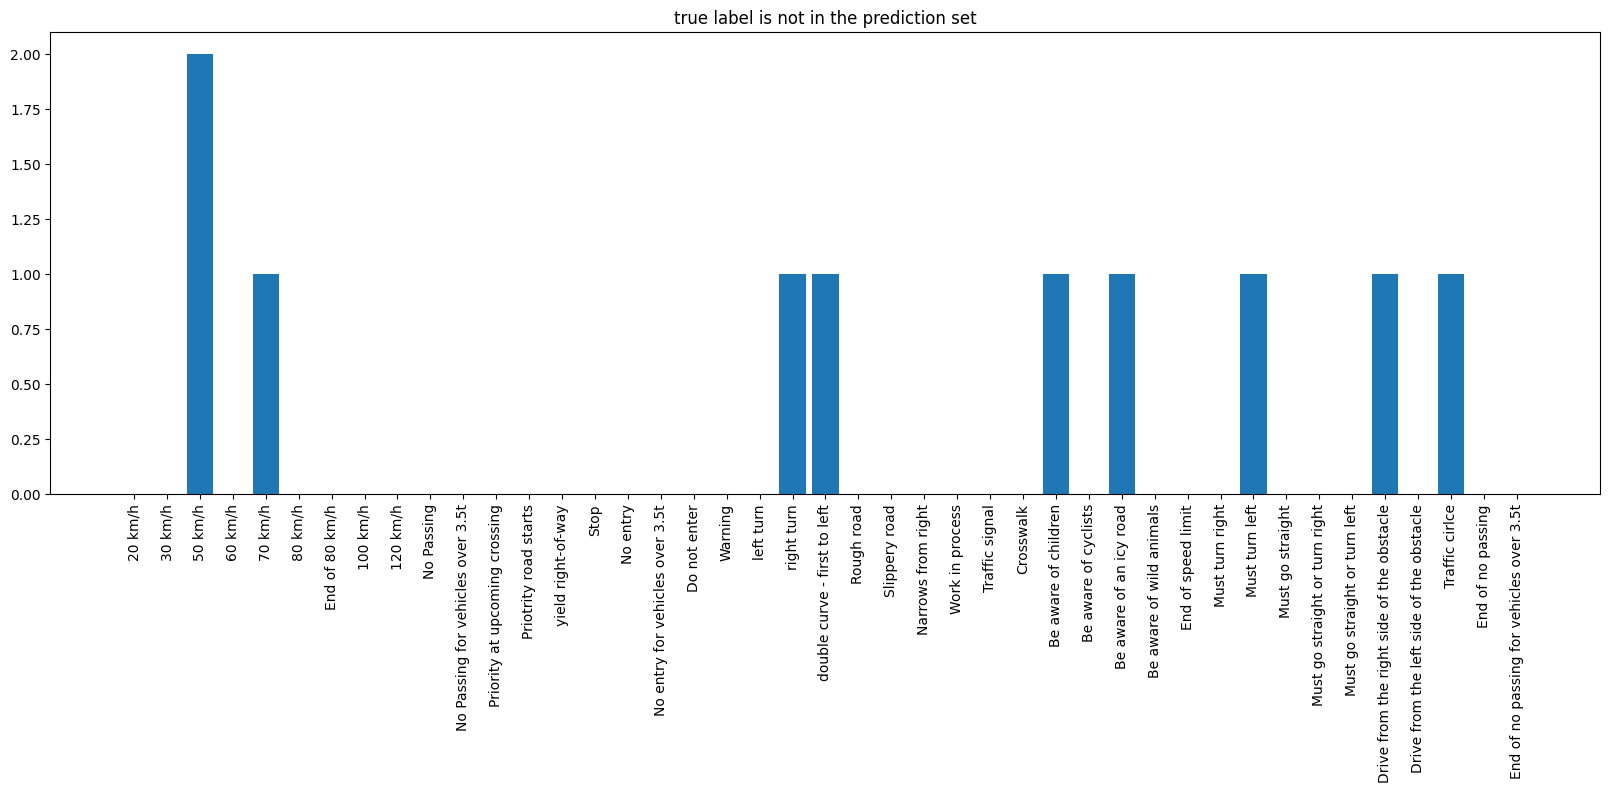

In [ ]:
plot_distribution(not_in_set_dist, labels, "true label is not in the prediction set")

# unfinished

In [ ]:
!unzip /content/gdrive/MyDrive/GtsrbCnn.zip -d /content/GTSRB

In [ ]:
adversarial_dataset = datasets.ImageFolder('/content/GTSRB/GtsrbCnn/StopSigns', transform=data_transforms)

In [ ]:
def conformal_prediction_stop(idx, data, data_smx, show_img = True, print_set = True):

  in_set_distribution = [0 for i in range(num_classes)]
  not_in_set_distribution = [0 for i in range(num_classes)]

  prediction_sets = get_prediction_sets(data_smx, q_hat)
  in_set = 0.0

  for i in idx:
    img, _ = data[i]
    true_label_id = 14

    if show_img:
      plt.title("True label: " + labels[true_label_id])
      plt.axis("off")
      img = img.swapaxes(0,1)
      img = img.swapaxes(1,2)
      plt.imshow(img.squeeze(), cmap="gray")
      plt.show()

    prediction_set = prediction_sets[i]

    if print_set:
      if get_in_set(prediction_set, true_label_id):
        s = Fore.GREEN + "prediction set" + Style.RESET_ALL + ": " + Fore.WHITE+ "{"
      else:
        s = Fore.RED + "prediction set" + Style.RESET_ALL + ": " + Fore.WHITE+ "{"
    t = True

    for j, b in enumerate(prediction_set):

      if b:
        label_string = labels[j]

        if label_string == labels[true_label_id]:
          in_set += 1.0
          in_set_distribution[j] += 1
          if print_set:
            label_string = Style.BRIGHT + Fore.YELLOW + labels[j] + Style.RESET_ALL + Fore.WHITE
        else:
          not_in_set_distribution[j] += 1

        if print_set:
          if t:
            s = s + label_string + ": " + str(data_smx[i][j])
            t = False
          else:
            s = s + ", " + label_string + ": " + str(data_smx[i][j])

    if print_set:
      if show_img:
        print(s+"}")
      else:
        space = ""
        for i in range(50 - len(labels[true_label_id])):
          space += " "
        print(labels[true_label_id] + space + s+"}")
  print("_________________________________________________________________________________________")
  print("We have a confidence of "+ Fore.RED + str(in_set/len(idx)) + Style.RESET_ALL +" that the true label is in the prediction set with an average prediction set size of "+ Fore.RED + str(get_average_prediction_set_size(idx, prediction_sets)) + Style.RESET_ALL)

  return in_set_distribution, not_in_set_distribution

In [ ]:
in_set_dist_critical, not_in_set_dist_critical = conformal_prediction_stop(range(len(adversarial_dataset)), adversarial_dataset, val_smx, show_img =  False, print_set = True)

In [ ]:
n = 500
alpha = 0.001

smx = []
labels = []

# generate softmax for calibration data
with torch.no_grad():
    for inputs, classes in cal_loader:
      inputs = inputs.to(device=device)
      classes = classes.to(device=device)
      cv_model.eval()
      smx.extend(model(inputs).softmax(dim=1).detach().cpu().numpy())
      classes = classes.data.cpu().numpy()
      labels.extend(classes)
smx = np.array(smx)
labels = np.array(labels)

# split softmax scores into calibration and validation
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.seed(42)
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

In [ ]:
# 1: get conformal scores. n = calib_Y.shape[0]
cal_scores = 1-cal_smx[np.arange(n),cal_labels]
# 2: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, method='higher')
# 3: form prediction sets
prediction_sets = val_smx >= (1-qhat)


In [ ]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

In [ ]:
# Prints prediction sets vs ground truth
for i in range(100):
  k = np.random.uniform(low=0, high=len(val_smx), size=1)
  print([j for j, x in enumerate(prediction_sets[int(k)]) if x], val_labels[int(k)])

**Visualization of the images (WIP)**

In [ ]:
for i in range(10):
  sample_idx = torch.randint(len(dataset), size=(1,)).item()
  img, label = dataset[sample_idx]
  img_transform = transforms.ToPILImage()
  img = img_transform(img)
  img = img.resize((100,100))
  img.show()
  print(label_dict[str(label)])

In [ ]:
img_transform = transforms.ToPILImage()
img , label= dataset[1]
img = img_transform(img)
img.show()

**TODO:**
1.   Conformal Prediction
2.   Model Performace Measures (Confusion Matrix, ...)
3.   Dropout Layers
4.   Weights & Biases
5.   Visualization






